In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import solve, block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from earth import Earth
from dynamics import SatelliteDynamics
from utils import get_form_initial_conditions

In [6]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
H = 50 # Window size [min]
invalid_rmse = 1e20 # [m]
mu = Earth().mu

In [7]:
def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def first_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def second_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec))) 

def total_differential_equation(x_vec):
    n = len(x_vec)
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(n // n_x):
        p_vec = x_vec[i * n_x : i * n_x + n_p] 
        v_vec = x_vec[i * n_x + n_p : i * n_x + n_x]
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec, function(p_vec)))
    return x_dot_vec

def total_first_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    first_order_der = np.zeros((n, n))
    for i in range(n // n_x):
        p_vec = x_vec[i * n_x : i * n_x + n_p]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + 3 : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = first_order_partial_derivatives(p_vec)
    return first_order_der

def total_second_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    second_order_der = np.zeros((n, n, n))
    for i in range(n // n_x):
        p_vec = x_vec[i * n_x : i * n_x + 3]
        aux = second_order_partial_derivatives(p_vec).reshape(n_p, n_p, n_p)
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux[:, :, j]
    return second_order_der.reshape((n * n, n))

def f(dt, x_old):
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)
    k4 = total_differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = total_second_order_partial_derivatives_for_the_differential_equation(x_old)
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [8]:
def h(x_vec):
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    distances = [np.linalg.norm(p_vecs[j] - p_vecs[i]) for (i, j) in [(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)]]
    return np.concatenate((p_vecs[0], np.array(distances).reshape(-1, 1)))

def Dh(x_vec):
    first_order_der = np.zeros((o, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    
    first_order_der[:n_p, :n_p] = np.eye(n_p)
    
    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        first_order_der[k, i * n_x : i * n_x + n_p] = -d.T / norm_d
        first_order_der[k, j * n_x : j * n_x + n_p] = d.T / norm_d
    
    return first_order_der

def Hh(x_vec):
    second_order_der = np.zeros((o, n, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]

    def hessian_distance(d, norm_d):
        I = np.eye(n_p)
        return -(I / norm_d - np.outer(d, d) / norm_d**3)

    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        hess_d = hessian_distance(d, norm_d)
        
        second_order_der[k, i * n_x : i * n_x + n_p, i * n_x : i * n_x + n_p] = -hess_d
        second_order_der[k, i * n_x : i * n_x + n_p, j * n_x : j * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, i * n_x : i * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, j * n_x : j * n_x + n_p] = -hess_d
    
    return second_order_der.reshape((o * n, n))

In [9]:
def J_tau(tau, dt, y, x_vec):
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec))

def DJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return -STM.T @ Dh(x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def HJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    
    Df_x = STM
    Hf_x = DSTM    
    h_x = h(x_vec)
    Dh_x = Dh(x_vec)
    Hh_x = Hh(x_vec)
    R_inv = np.linalg.inv(R)
    return - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x

In [10]:
def J(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    J_x = 0
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        J_x += 1 / 2 * (y - h_x).T @ R_inv @ (y - h_x)
        x_vec = f(dt, x_vec)
    return J_x

def DJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DJ_x = np.zeros((n, 1))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        DJ_x += -STM.T @ Dh(x_vec).T @ R_inv @ (y - h(x_vec))
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return DJ_x

def HJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    HJ_x = np.zeros((n, n))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        Dh_x = Dh(x_vec)
        Hh_x = Hh(x_vec)
        Df_x = STM
        Hf_x = DSTM
        HJ_x += - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return HJ_x

In [11]:
class CentralizedNewton:
    def __init__(self, tolerance=1e-6, max_iter=20):
        self.grad_tol = tolerance
        self.max_iter = max_iter
        self.iterations = None
        
        # Storage for results
        self.cost_values = []
        self.gradient_norm_values = []

    def solve(self, k, dt, Y, x_init, x_true):
        x = x_init

        prev_cost_value = None
        prev_gradient_norm_value = None
        prev_global_estimation_error = None

        for iteration in range(self.max_iter):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            J_x = J(k, dt, Y, x)
            DJ_x = DJ(k, dt, Y, x)
            HJ_x = HJ(k, dt, Y, x)

            # Convergence tracking
            cost_value = J_x[0][0]
            gradient_norm_value = np.linalg.norm(DJ_x)

            # Store the norms
            self.cost_values.append(cost_value)
            self.gradient_norm_values.append(gradient_norm_value)

            if prev_cost_value is not None:
                cost_value_change = (cost_value - prev_cost_value) / abs(prev_cost_value) * 100
                gradient_norm_value_change = (gradient_norm_value - prev_gradient_norm_value) / abs(prev_gradient_norm_value) * 100
                global_estimation_error_change = (np.linalg.norm(x - x_true) - prev_global_estimation_error) / abs(prev_global_estimation_error) * 100
            prev_cost_value = cost_value
            prev_gradient_norm_value = gradient_norm_value
            prev_global_estimation_error = np.linalg.norm(x - x_true)

            # Check convergence and print metrics
            if gradient_norm_value < self.grad_tol or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nCost function = {cost_value} ({cost_value_change:.2f}%)\nGradient norm = {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error = {np.linalg.norm(x - x_true)} ({global_estimation_error_change:.2f}%)")
                print(f"Final position estimation errors: {np.linalg.norm(x[:n_p, :] - x_true[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true[3 * n_x : 3 * n_x + n_p, :])} m\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_value}\nGradient norm: {gradient_norm_value}\nGlobal estimation error: {np.linalg.norm(x - X_true)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_value} ({cost_value_change:.2f}%)\nGradient norm: {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error: {np.linalg.norm(x - x_true)} ({global_estimation_error_change:.2f}%)")
                    
            # Print estimation errors 
            print(f"Position estimation errors: {np.linalg.norm(x[:n_p, :] - x_true[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true[3 * n_x : 3 * n_x + n_p, :])} m\n")
                
            # Solve for the Newton step - this is one iteration
            delta_x = solve(HJ_x, -DJ_x)
            x += delta_x
        
            # Save the current iteration
            self.iterations = iteration + 1
            
        # Propagate window initial conditions getting estimate at timestamp k
        x_init = x
        for _ in range(H - 1):
            x = f(dt, x)

        return x_init, x

In [12]:
def give_me_the_plots(algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, algorithm_class.cost_values, '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$J(x_n)$')
    axs[0].set_title('Cost Function')
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, algorithm_class.gradient_norm_values, '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$||\nabla J(x_n)||_2$')
    axs[1].set_title('Gradient Norm')
    axs[1].grid()

    plt.tight_layout()
    plt.show()

In [13]:
np.random.seed(42)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((n, 1, K))
X_true[:, :, 0] = X_initial
for k in range(K - 1):
    X_true[:, :, k + 1] = f(dt, X_true[:, :, k])

# Observations
Y = np.zeros((o, 1, K))
for k in range(K):
    Y[:, :, k] = h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))
    
# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = f(dt, X_est[:, :, k])
position_estimation_error_1_initial = np.linalg.norm(X_est[:n_p, :, :] - X_true[:n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_2_initial = np.linalg.norm(X_est[n_x:n_x + n_p, :, :] - X_true[n_x:n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_3_initial = np.linalg.norm(X_est[2 * n_x:2 * n_x + n_p, :, :] - X_true[2 * n_x:2 * n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_4_initial = np.linalg.norm(X_est[3 * n_x:3 * n_x + n_p, :, :] - X_true[3 * n_x:3 * n_x + n_p, :, :], axis=0).reshape(-1, 1)

MC run:   0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------ Monte Carlo run #1 ------------------------------------



Windows:   0%|          | 0/346 [00:00<?, ?it/s]

Before applying the algorithm
Cost function: 292380319.35149795
Gradient norm: 5453576729.6912775
Global estimation error: 1893170686.2411766
Position estimation errors: 91.9030372717269 m, 324.53997228141645 m, 157.5789119891446 m, 177.4146593769755 m

Iteration 1
Cost function: 1228882.565911673 (-99.58%)
Gradient norm: 24044750.49670749 (-99.56%)
Global estimation error: 814.5433331547956 (97.51%)
Position estimation errors: 0.06108486287866725 m, 372.72438506798346 m, 268.46905760747075 m, 672.6668466878598 m

Iteration 2
Cost function: 59224.43924371849 (-95.18%)
Gradient norm: 8160482.057251052 (-66.06%)
Global estimation error: 427.1042541659698 (-47.57%)
Position estimation errors: 0.04448321263378177 m, 105.09054660466892 m, 218.0892669069924 m, 351.86765554498487 m

Iteration 3
Cost function: 23380.808754252357 (-60.52%)
Gradient norm: 811228.5089215928 (-90.06%)
Global estimation error: 271.10826024354134 (-36.52%)
Position estimation errors: 0.04473857495983007 m, 25.604372

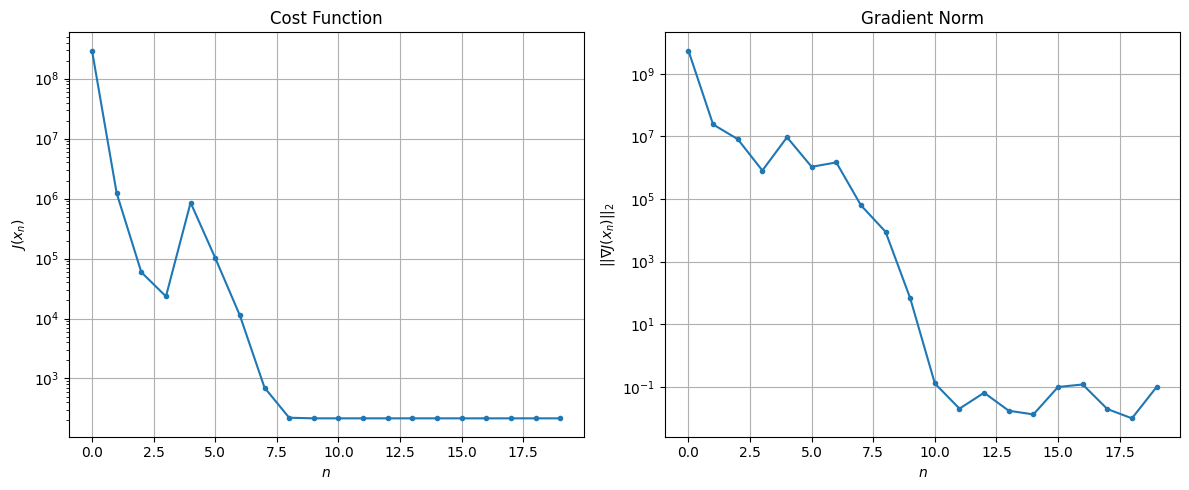


Windows:   0%|          | 1/346 [00:20<1:58:05, 20.54s/it]

Before applying the algorithm
Cost function: 218.94949838952482
Gradient norm: 193448.5212577673
Global estimation error: 1892833329.2120905
Position estimation errors: 0.043808756248151524 m, 0.8110491897772757 m, 0.541992895924909 m, 1.2348371525670465 m

Iteration 1
Cost function: 217.0646904472677 (-0.86%)
Gradient norm: 9.041349213287793 (-100.00%)
Global estimation error: 1.7763004736857597 (12.83%)
Position estimation errors: 0.0367015187704354 m, 1.1528615746071968 m, 0.7349482324751591 m, 1.1334264535034004 m

Iteration 2
Cost function: 217.06468808250324 (-0.00%)
Gradient norm: 0.3054220454658489 (-96.62%)
Global estimation error: 1.7761772141124597 (-0.01%)
Position estimation errors: 0.03670151505813092 m, 1.1528770746679602 m, 0.7354114932622998 m, 1.13291692147289 m

Iteration 3
Cost function: 217.06468795734293 (-0.00%)
Gradient norm: 0.2211833562947977 (-27.58%)
Global estimation error: 1.7761772128673594 (-0.00%)
Position estimation errors: 0.03670151487104839 m, 1.152

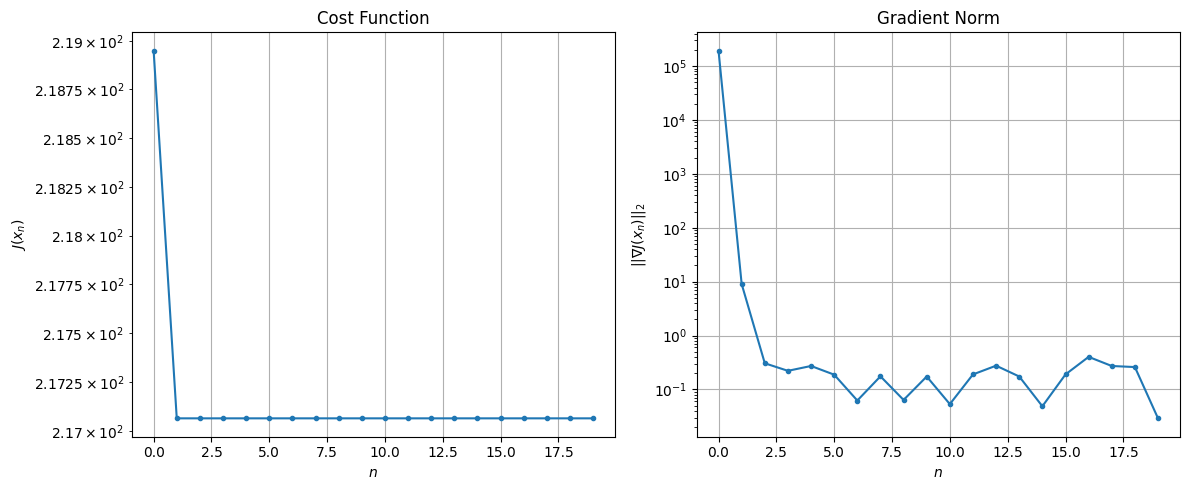


Windows:   1%|          | 2/346 [00:41<1:57:38, 20.52s/it]

Before applying the algorithm
Cost function: 214.67821963861704
Gradient norm: 39606.072554186656
Global estimation error: 1892512113.2645845
Position estimation errors: 0.035392523301978854 m, 1.1798120627567639 m, 0.7315320812461004 m, 1.1538987524872155 m

Iteration 1
Cost function: 213.456874376829 (-0.57%)
Gradient norm: 50.56397699329097 (-99.87%)
Global estimation error: 0.7402078961260834 (-59.00%)
Position estimation errors: 0.029763998075278818 m, 0.24930797150072098 m, 0.12183279031248273 m, 0.6855818211125216 m

Iteration 2
Cost function: 213.45687192915156 (-0.00%)
Gradient norm: 0.030156802051492963 (-99.94%)
Global estimation error: 0.7395197982071715 (-0.09%)
Position estimation errors: 0.029763997588304718 m, 0.24860282335656989 m, 0.12349163850310577 m, 0.6847980581861081 m

Iteration 3
Cost function: 213.4568719232321 (-0.00%)
Gradient norm: 0.03652222192510015 (21.11%)
Global estimation error: 0.7395197850541879 (-0.00%)
Position estimation errors: 0.029763997778907

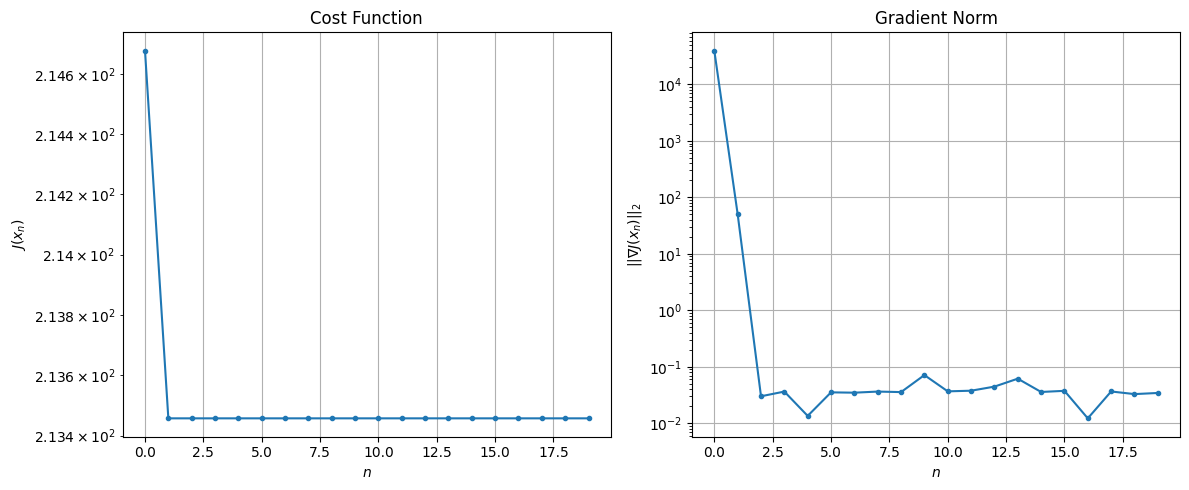


Windows:   1%|          | 3/346 [01:01<1:58:03, 20.65s/it]

Before applying the algorithm
Cost function: 214.98950656574848
Gradient norm: 126847.29416664987
Global estimation error: 1892228812.5039983
Position estimation errors: 0.028874951336558725 m, 0.2903261513783586 m, 0.12199151149562806 m, 0.66189573758857 m

Iteration 1
Cost function: 212.20623547193995 (-1.29%)
Gradient norm: 31.933293908243698 (-99.97%)
Global estimation error: 3.1808612831264225 (333.62%)
Position estimation errors: 0.03975458723968311 m, 0.40565778430268856 m, 0.7172999766563738 m, 3.0720024012929987 m

Iteration 2
Cost function: 212.20611449816457 (-0.00%)
Gradient norm: 0.2502687222516198 (-99.22%)
Global estimation error: 3.2027619045463225 (0.69%)
Position estimation errors: 0.03975458547499221 m, 0.4158795441802303 m, 0.7246370861270913 m, 3.091605817276017 m

Iteration 3
Cost function: 212.20611459028328 (0.00%)
Gradient norm: 0.05596179096528693 (-77.64%)
Global estimation error: 3.202764060206242 (0.00%)
Position estimation errors: 0.03975458374523438 m, 0.

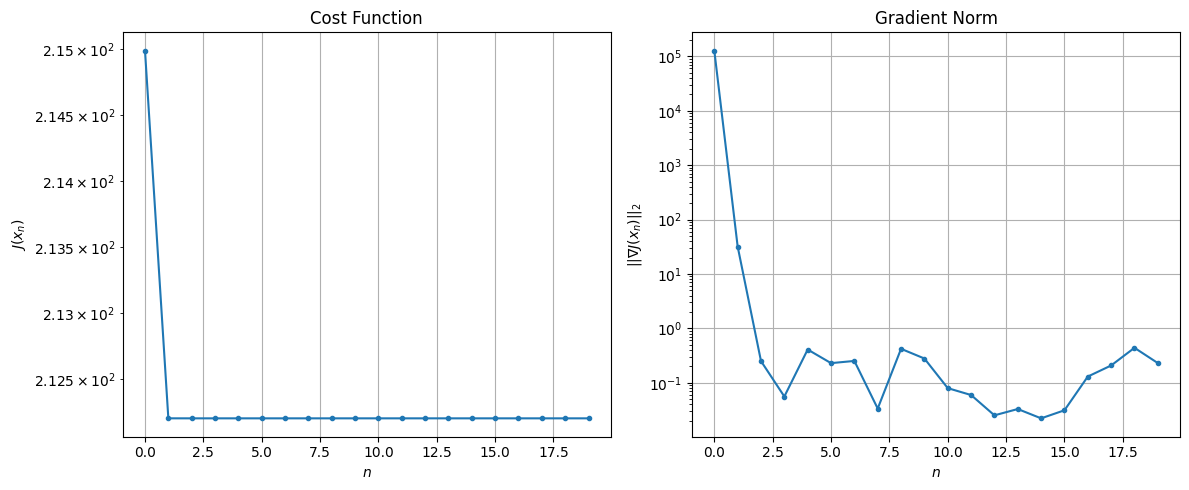


Windows:   1%|          | 4/346 [01:23<1:59:25, 20.95s/it]

Before applying the algorithm
Cost function: 213.67924662680346
Gradient norm: 52971.97196392885
Global estimation error: 1891984544.5717502
Position estimation errors: 0.03805483348943279 m, 0.3582055781611268 m, 0.7285679460843388 m, 2.914004776192372 m

Iteration 1
Cost function: 212.66183087810157 (-0.48%)
Gradient norm: 6.447120528952089 (-99.99%)
Global estimation error: 4.234608375321261 (39.98%)
Position estimation errors: 0.040894431992009705 m, 0.5223599203135156 m, 0.4541289552448353 m, 4.177451571935686 m

Iteration 2
Cost function: 212.66182852489192 (-0.00%)
Gradient norm: 0.09949100970352018 (-98.46%)
Global estimation error: 4.238911579605355 (0.10%)
Position estimation errors: 0.04089443180824014 m, 0.5240845115552174 m, 0.4532943611555533 m, 4.1816883541851775 m

Iteration 3
Cost function: 212.66182835021576 (-0.00%)
Gradient norm: 0.024424439006844198 (-75.45%)
Global estimation error: 4.238911637183533 (0.00%)
Position estimation errors: 0.0408944338181958 m, 0.5240

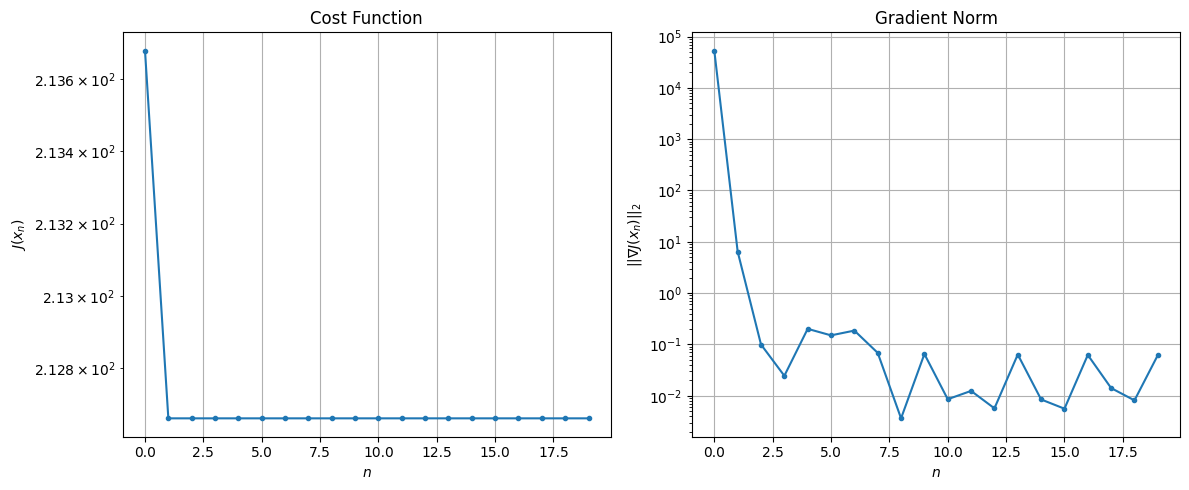


Windows:   1%|▏         | 5/346 [01:43<1:58:31, 20.86s/it]

Before applying the algorithm
Cost function: 212.26168409953257
Gradient norm: 132290.58267365012
Global estimation error: 1891780512.2887983
Position estimation errors: 0.04014055025108396 m, 0.4688846328348326 m, 0.5502442759950399 m, 3.9209351768436984 m

Iteration 1
Cost function: 211.1735105369504 (-0.51%)
Gradient norm: 12.451008506836475 (-99.99%)
Global estimation error: 3.6845939640450966 (-7.59%)
Position estimation errors: 0.04182977711983524 m, 0.4449309849000298 m, 1.1760877673829324 m, 3.4631362711783664 m

Iteration 2
Cost function: 211.1735047301421 (-0.00%)
Gradient norm: 0.3296843318681545 (-97.35%)
Global estimation error: 3.6885351263973396 (0.11%)
Position estimation errors: 0.04182977896140464 m, 0.4449589929027211 m, 1.1710727226063886 m, 3.469022577543345 m

Iteration 3
Cost function: 211.17350476037728 (0.00%)
Gradient norm: 0.21647304103870246 (-34.34%)
Global estimation error: 3.6885351824265893 (0.00%)
Position estimation errors: 0.04182977742188353 m, 0.444

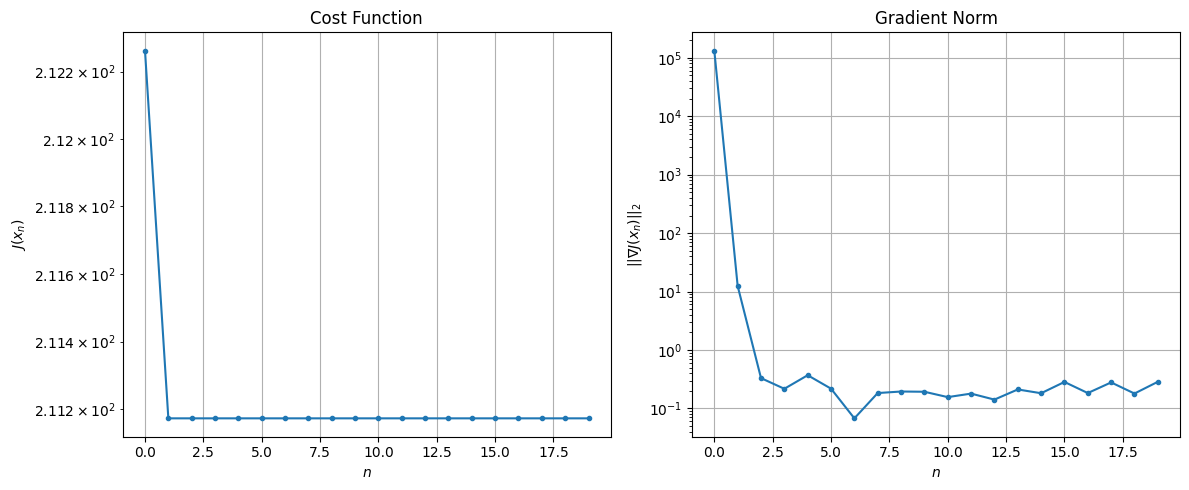


Windows:   2%|▏         | 6/346 [02:05<1:58:37, 20.93s/it]

Before applying the algorithm
Cost function: 209.97547953350875
Gradient norm: 39260.991906046496
Global estimation error: 1891617619.899222
Position estimation errors: 0.041068527822370283 m, 0.44447598096112034 m, 1.1652489870279135 m, 3.256043042017499 m

Iteration 1
Cost function: 208.85415928081602 (-0.53%)
Gradient norm: 7.5560099642247 (-99.98%)
Global estimation error: 2.5699015591780787 (-26.30%)
Position estimation errors: 0.049190184228397826 m, 0.5619974085309486 m, 0.9509601746345702 m, 2.319870083996089 m

Iteration 2
Cost function: 208.8541568775867 (-0.00%)
Gradient norm: 0.02209483726678106 (-99.71%)
Global estimation error: 2.5697570546404576 (-0.01%)
Position estimation errors: 0.049190180496787694 m, 0.5628385246982625 m, 0.9488318595269751 m, 2.320377502862097 m

Iteration 3
Cost function: 208.85415695683173 (0.00%)
Gradient norm: 0.3103437910185474 (1304.60%)
Global estimation error: 2.5697570515272323 (-0.00%)
Position estimation errors: 0.049190178831524496 m, 0

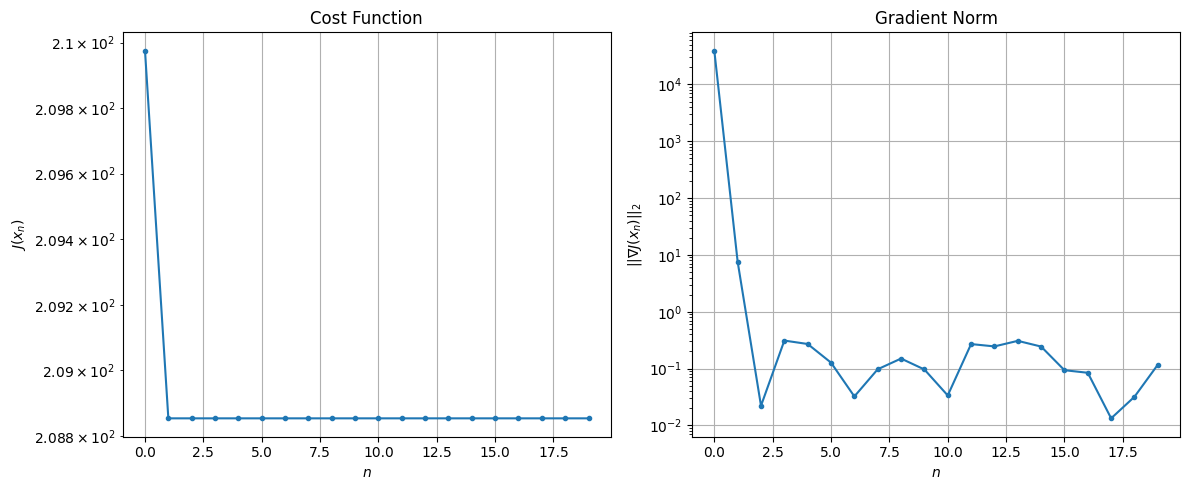


Windows:   2%|▏         | 7/346 [02:25<1:57:57, 20.88s/it]

Before applying the algorithm
Cost function: 214.92321608410506
Gradient norm: 170521.544028352
Global estimation error: 1891496626.3023748
Position estimation errors: 0.048417777821379994 m, 0.5850952007153822 m, 0.9108853384908391 m, 2.1782749877570438 m

Iteration 1
Cost function: 213.89077915672664 (-0.48%)
Gradient norm: 5.774812290630104 (-100.00%)
Global estimation error: 2.99319944898514 (23.03%)
Position estimation errors: 0.04406679703320646 m, 0.7636142319460009 m, 2.3461034101905285 m, 1.6941023765405159 m

Iteration 2
Cost function: 213.89077759053956 (-0.00%)
Gradient norm: 0.10163463708665839 (-98.24%)
Global estimation error: 2.9929226863484253 (-0.01%)
Position estimation errors: 0.04406679120586893 m, 0.7619965572761139 m, 2.3479846108254083 m, 1.691733881258208 m

Iteration 3
Cost function: 213.8907775635389 (-0.00%)
Gradient norm: 0.08071681071326328 (-20.58%)
Global estimation error: 2.992922677721037 (-0.00%)
Position estimation errors: 0.044066791193368156 m, 0.7

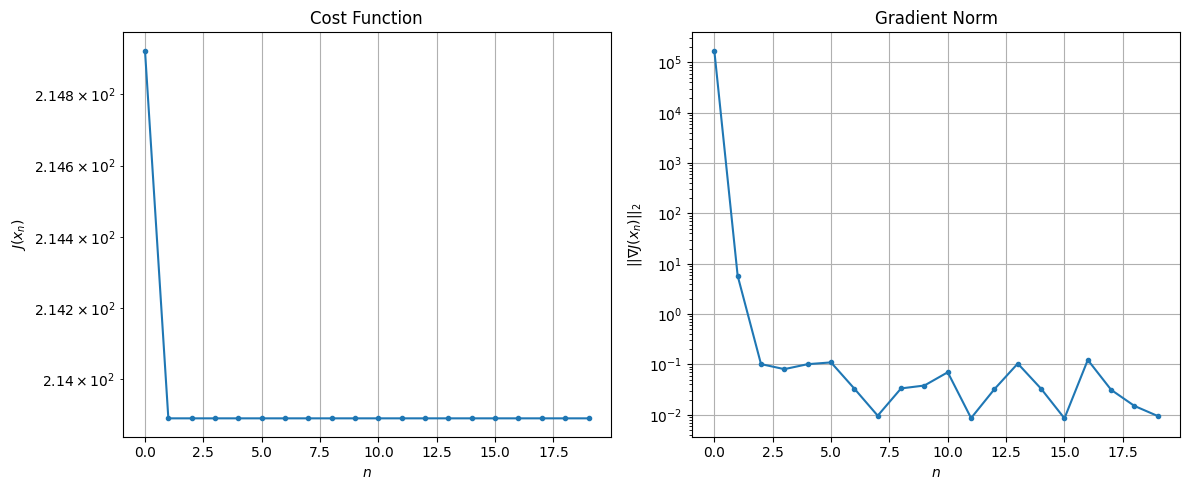


Windows:   2%|▏         | 8/346 [02:46<1:56:56, 20.76s/it]

Before applying the algorithm
Cost function: 214.25302295511963
Gradient norm: 128931.87240204659
Global estimation error: 1891417995.087397
Position estimation errors: 0.043292836673720296 m, 0.774059213371045 m, 2.211267306134609 m, 1.6920706412497402 m

Iteration 1
Cost function: 213.10145063173485 (-0.54%)
Gradient norm: 31.30031693989 (-99.98%)
Global estimation error: 3.777131764078554 (30.68%)
Position estimation errors: 0.05600853126728374 m, 0.7950675071277088 m, 3.567334052593888 m, 0.9516084058146745 m

Iteration 2
Cost function: 213.10144120431335 (-0.00%)
Gradient norm: 0.17744306981833094 (-99.43%)
Global estimation error: 3.7830627995376402 (0.16%)
Position estimation errors: 0.05600853201827424 m, 0.7933864534132671 m, 3.5735128914125247 m, 0.9533868028278666 m

Iteration 3
Cost function: 213.1014412493095 (0.00%)
Gradient norm: 0.06223676503498152 (-64.93%)
Global estimation error: 3.7830633517083165 (0.00%)
Position estimation errors: 0.05600853207048678 m, 0.79338631

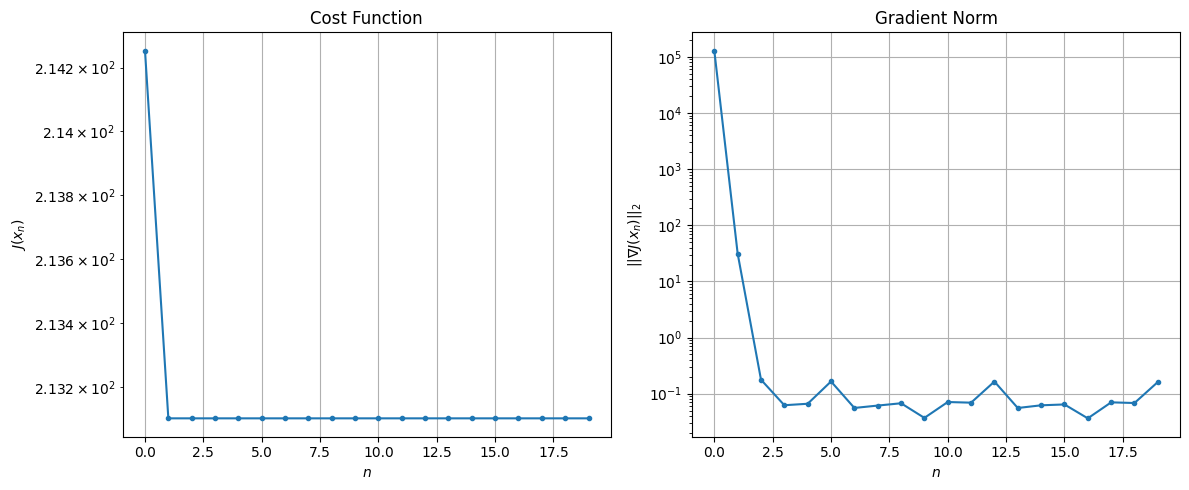


Windows:   3%|▎         | 9/346 [03:06<1:55:46, 20.61s/it]

Before applying the algorithm
Cost function: 211.69967479914223
Gradient norm: 108505.92103720592
Global estimation error: 1891381995.5522096
Position estimation errors: 0.0540963256848254 m, 0.8103861809019681 m, 3.4103667550351564 m, 0.8596800442394263 m

Iteration 1
Cost function: 210.2092302246396 (-0.70%)
Gradient norm: 47.88714034489089 (-99.96%)
Global estimation error: 3.467403715997819 (-3.94%)
Position estimation errors: 0.07101529258654103 m, 0.7599900123251861 m, 1.936629579845629 m, 2.773032687983152 m

Iteration 2
Cost function: 210.20919120576127 (-0.00%)
Gradient norm: 0.05417743598993459 (-99.89%)
Global estimation error: 3.4729133591135875 (0.16%)
Position estimation errors: 0.07101529370858553 m, 0.7583738781580323 m, 1.9499452024719308 m, 2.7710378150450605 m

Iteration 3
Cost function: 210.2091912710309 (0.00%)
Gradient norm: 0.009502434364021832 (-82.46%)
Global estimation error: 3.4729126120331975 (-0.00%)
Position estimation errors: 0.07101529234713544 m, 0.7583

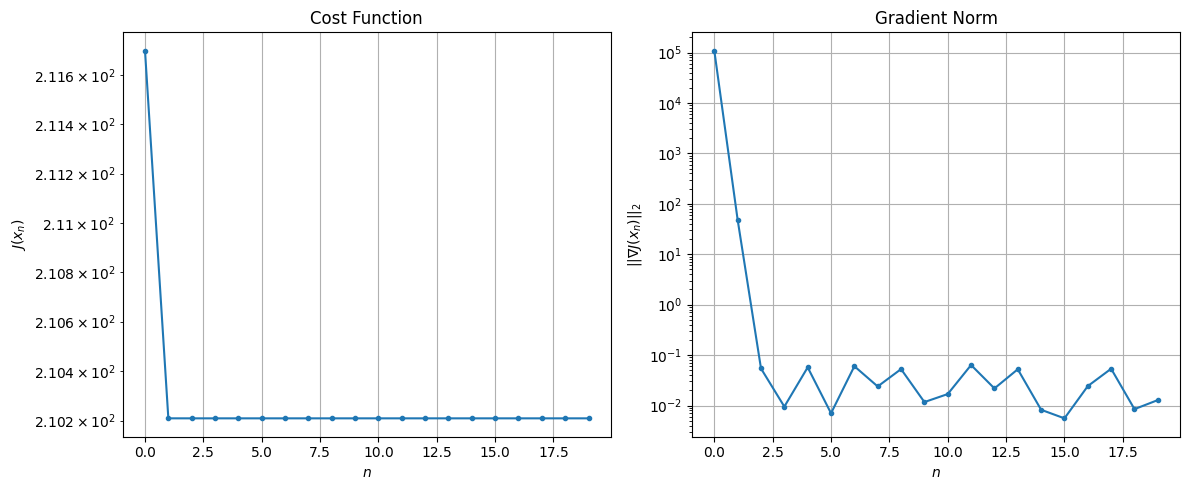


Windows:   3%|▎         | 10/346 [03:24<1:51:31, 19.92s/it]

Before applying the algorithm
Cost function: 213.16699348293295
Gradient norm: 36994.76439434357
Global estimation error: 1891388881.9721642
Position estimation errors: 0.06809679290197762 m, 0.766662940788536 m, 1.8284056342476647 m, 2.708437661034174 m

Iteration 1
Cost function: 212.21122348396338 (-0.45%)
Gradient norm: 20.49242264071202 (-99.94%)
Global estimation error: 4.632299491662295 (37.98%)
Position estimation errors: 0.06802836572291598 m, 0.7905608843552893 m, 2.290611373184327 m, 3.94736047949951 m

Iteration 2
Cost function: 212.21122098585332 (-0.00%)
Gradient norm: 0.21148739177527634 (-98.97%)
Global estimation error: 4.626408064307589 (-0.13%)
Position estimation errors: 0.06802836842993347 m, 0.7892545895843366 m, 2.2945395365911123 m, 3.9384210395892656 m

Iteration 3
Cost function: 212.21122102948289 (0.00%)
Gradient norm: 0.09478716849225009 (-55.18%)
Global estimation error: 4.626407903603663 (-0.00%)
Position estimation errors: 0.06802836755937698 m, 0.7892545

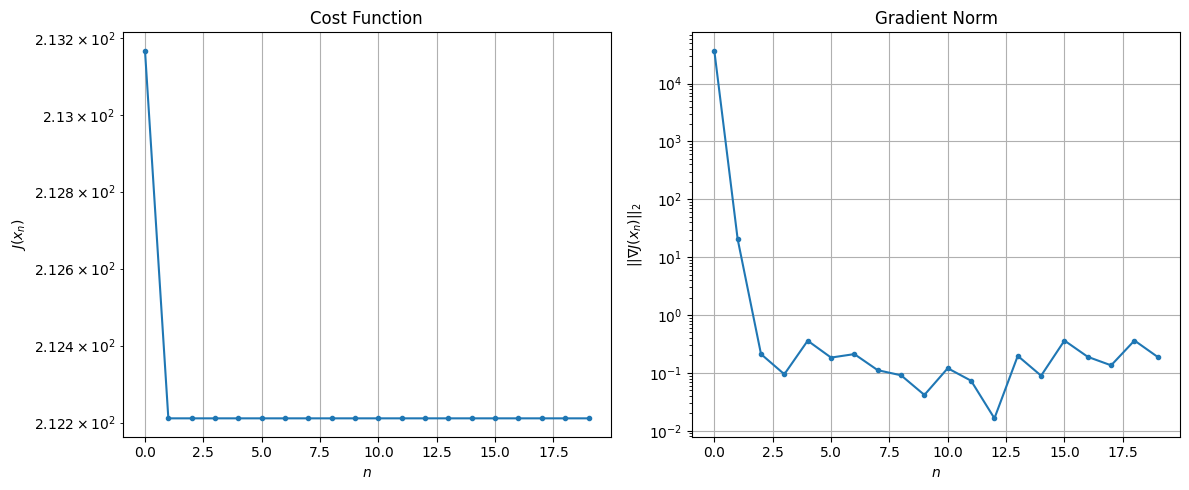


Windows:   3%|▎         | 11/346 [03:43<1:48:06, 19.36s/it]

Before applying the algorithm
Cost function: 215.86469125072875
Gradient norm: 101732.79264124091
Global estimation error: 1891438586.841682
Position estimation errors: 0.06554771353961705 m, 0.8133498411221717 m, 2.1516097829258705 m, 3.7267351703546643 m

Iteration 1
Cost function: 214.35447861711407 (-0.70%)
Gradient norm: 36.88203107127436 (-99.96%)
Global estimation error: 9.265788360739203 (111.55%)
Position estimation errors: 0.06475507753713491 m, 1.397452302647919 m, 2.5545834284212123 m, 8.796122128572254 m

Iteration 2
Cost function: 214.35438870263778 (-0.00%)
Gradient norm: 0.09354773542135256 (-99.75%)
Global estimation error: 9.224041588401624 (-0.45%)
Position estimation errors: 0.0647550648251777 m, 1.3910664445778131 m, 2.549196854343926 m, 8.754722928488146 m

Iteration 3
Cost function: 214.3543887874593 (0.00%)
Gradient norm: 0.10087817857361189 (7.84%)
Global estimation error: 9.224030269941013 (-0.00%)
Position estimation errors: 0.06475506331087309 m, 1.391065162

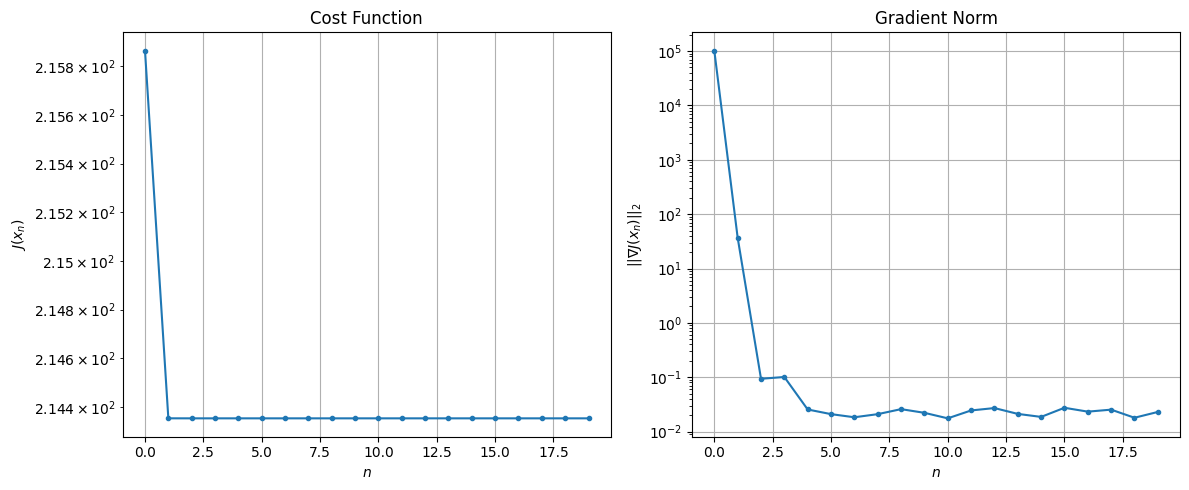


Windows:   3%|▎         | 12/346 [04:04<1:51:04, 19.95s/it]

Before applying the algorithm
Cost function: 207.49337550120123
Gradient norm: 65287.858377262484
Global estimation error: 1891530913.9541862
Position estimation errors: 0.062207834119221844 m, 1.3732857190048156 m, 2.513420015956542 m, 8.284487855902473 m

Iteration 1
Cost function: 205.69842448993268 (-0.87%)
Gradient norm: 12.21711277641438 (-99.98%)
Global estimation error: 12.199985800994302 (39.18%)
Position estimation errors: 0.09057959643314042 m, 1.4730971433486446 m, 3.067706439165029 m, 11.715391816390195 m

Iteration 2
Cost function: 205.69841447120416 (-0.00%)
Gradient norm: 0.013175313553125869 (-99.89%)
Global estimation error: 12.2108483977892 (0.09%)
Position estimation errors: 0.09057959707651005 m, 1.473766727290171 m, 3.0709738716500907 m, 11.725763904822667 m

Iteration 3
Cost function: 205.69841446868418 (-0.00%)
Gradient norm: 0.121943783856132 (825.55%)
Global estimation error: 12.210848683683823 (0.00%)
Position estimation errors: 0.09057959701690402 m, 1.47376

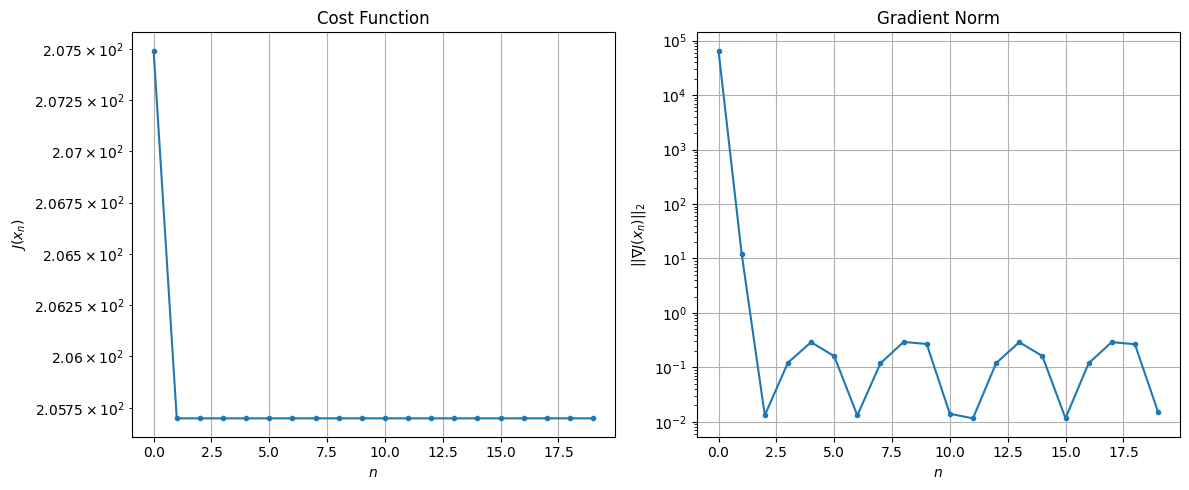


Windows:   4%|▍         | 13/346 [04:24<1:51:47, 20.14s/it]

Before applying the algorithm
Cost function: 209.66836314281247
Gradient norm: 46533.075528587135
Global estimation error: 1891665416.0218167
Position estimation errors: 0.08619570387509563 m, 1.4400146341693483 m, 3.0381385841708624 m, 11.07293152281262 m

Iteration 1
Cost function: 207.40222205176147 (-1.08%)
Gradient norm: 57.32198431336003 (-99.88%)
Global estimation error: 7.80260909378886 (-32.58%)
Position estimation errors: 0.10592558310765988 m, 1.4391884548765956 m, 4.230376805640053 m, 6.39547048690005 m

Iteration 2
Cost function: 207.40207761476915 (-0.00%)
Gradient norm: 0.016861175928148255 (-99.97%)
Global estimation error: 7.781040702597106 (-0.28%)
Position estimation errors: 0.10592556047113749 m, 1.4359214536351474 m, 4.26581263334102 m, 6.346199837584711 m

Iteration 3
Cost function: 207.40207761025212 (-0.00%)
Gradient norm: 0.07503143078707084 (345.00%)
Global estimation error: 7.781034203815815 (-0.00%)
Position estimation errors: 0.10592555993086725 m, 1.435920

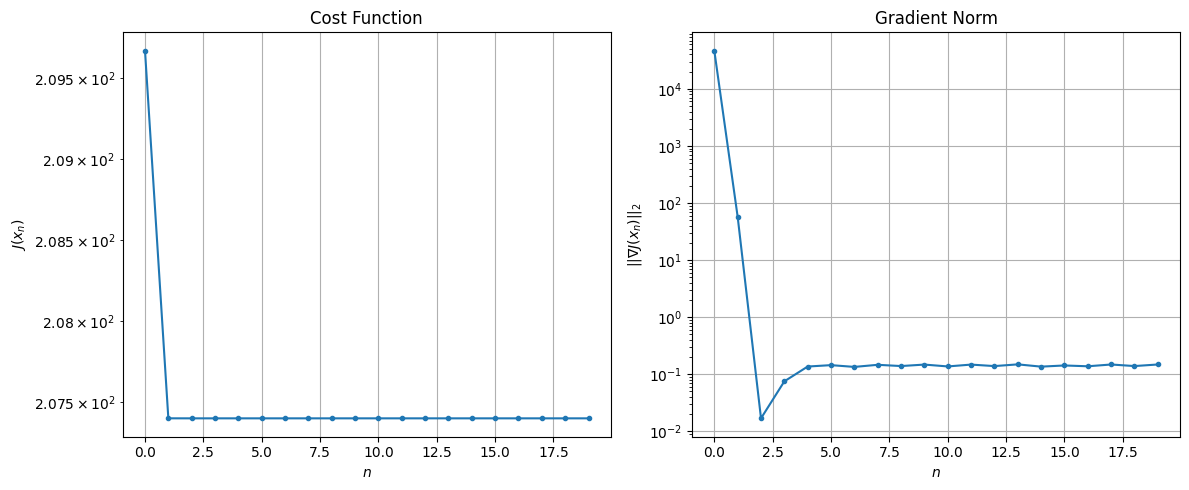


Windows:   4%|▍         | 14/346 [04:45<1:51:36, 20.17s/it]

Before applying the algorithm
Cost function: 204.39341425043187
Gradient norm: 65229.73185581677
Global estimation error: 1891841364.2860904
Position estimation errors: 0.10054605095568742 m, 1.41106342685682 m, 3.976668901009223 m, 5.952968460007426 m

Iteration 1
Cost function: 203.2678134748277 (-0.55%)
Gradient norm: 14.726910174089841 (-99.98%)
Global estimation error: 9.73395664802435 (33.39%)
Position estimation errors: 0.10314456412522514 m, 1.7928614117164667 m, 3.7176244732728816 m, 8.814989696153068 m

Iteration 2
Cost function: 203.2678081793803 (-0.00%)
Gradient norm: 0.04398316768892304 (-99.70%)
Global estimation error: 9.732260524145177 (-0.02%)
Position estimation errors: 0.10314455998156138 m, 1.7921435973744846 m, 3.7219377354662306 m, 8.811442039583675 m

Iteration 3
Cost function: 203.26780818340487 (0.00%)
Gradient norm: 0.08045613775466182 (82.92%)
Global estimation error: 9.732260367151648 (-0.00%)
Position estimation errors: 0.10314456039878558 m, 1.79214358768

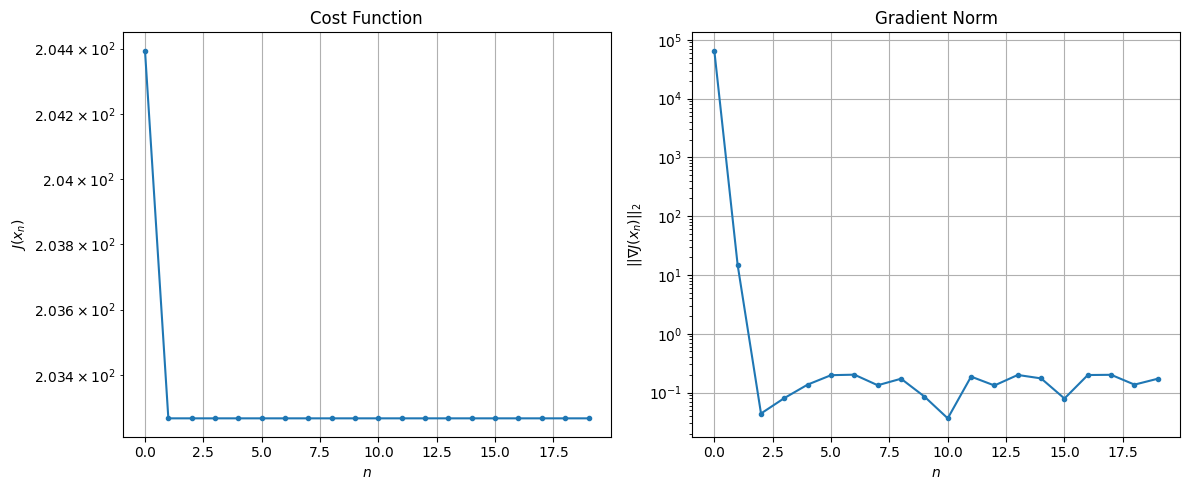


Windows:   4%|▍         | 15/346 [05:05<1:51:52, 20.28s/it]

Before applying the algorithm
Cost function: 205.75934036511052
Gradient norm: 47015.96335425298
Global estimation error: 1892058169.324078
Position estimation errors: 0.09760341185797865 m, 1.7224322652545943 m, 3.492578514849918 m, 8.28288320480671 m

Iteration 1
Cost function: 204.57005761413706 (-0.58%)
Gradient norm: 25.806156931301814 (-99.95%)
Global estimation error: 8.140407013533014 (-11.06%)
Position estimation errors: 0.09480001641919424 m, 1.604104955192742 m, 1.9375845552918247 m, 7.741430889167717 m

Iteration 2
Cost function: 204.5700563393503 (-0.00%)
Gradient norm: 0.03795809158413985 (-99.85%)
Global estimation error: 8.13734229835925 (-0.04%)
Position estimation errors: 0.09480001399458518 m, 1.6040552270882653 m, 1.938815862973145 m, 7.737910059892746 m

Iteration 3
Cost function: 204.57005635359965 (0.00%)
Gradient norm: 0.06543619814229001 (72.39%)
Global estimation error: 8.137342255675806 (-0.00%)
Position estimation errors: 0.09480001412905886 m, 1.60405522643

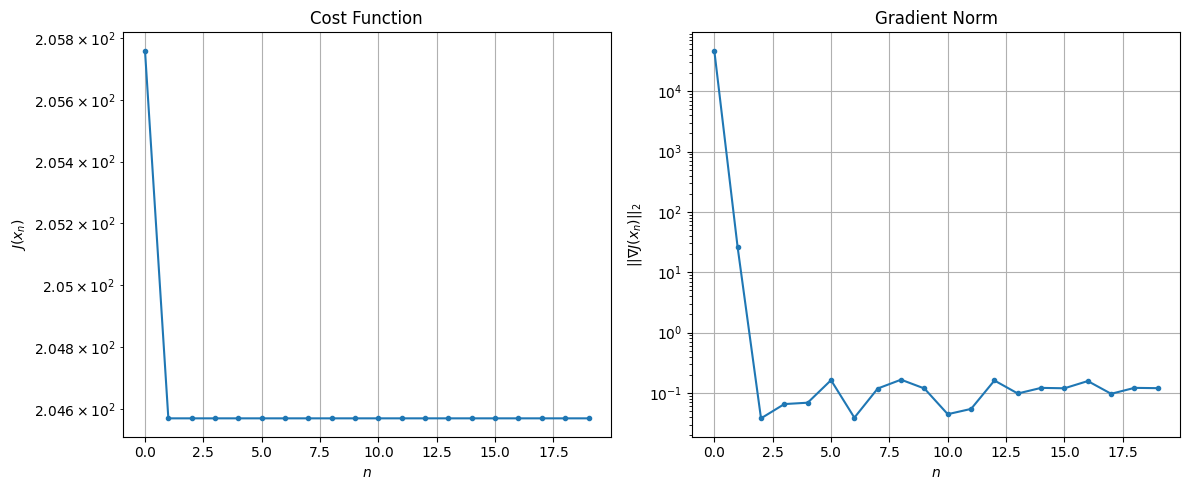


Windows:   5%|▍         | 16/346 [05:26<1:52:05, 20.38s/it]

Before applying the algorithm
Cost function: 200.0725958142564
Gradient norm: 62055.40382122529
Global estimation error: 1892314683.125365
Position estimation errors: 0.08974336086596076 m, 1.549010350175804 m, 1.857133277039731 m, 7.231872554915669 m

Iteration 1
Cost function: 197.67327829518476 (-1.20%)
Gradient norm: 22.708941684133002 (-99.96%)
Global estimation error: 7.4644348862241445 (-2.12%)
Position estimation errors: 0.06478969180850283 m, 2.60309984937391 m, 2.7369878771826635 m, 6.4378777167229355 m

Iteration 2
Cost function: 197.6732715150377 (-0.00%)
Gradient norm: 0.1731641232513568 (-99.24%)
Global estimation error: 7.461906869955322 (-0.03%)
Position estimation errors: 0.06478969142972228 m, 2.6039622761172634 m, 2.741677193144248 m, 6.432600843194449 m

Iteration 3
Cost function: 197.6732715303883 (0.00%)
Gradient norm: 0.053557971908217386 (-69.07%)
Global estimation error: 7.461906778277415 (-0.00%)
Position estimation errors: 0.06478969113335213 m, 2.60396228331

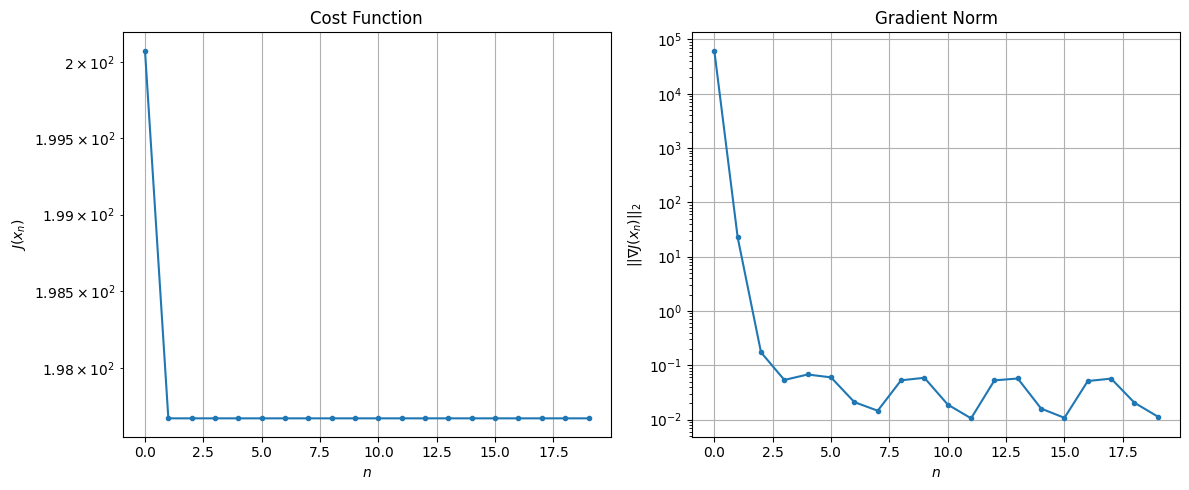


Windows:   5%|▍         | 17/346 [05:46<1:51:45, 20.38s/it]

Before applying the algorithm
Cost function: 198.00912330595327
Gradient norm: 110553.24354135037
Global estimation error: 1892609961.359926
Position estimation errors: 0.06273359186363567 m, 2.4680718625265676 m, 2.565769178217887 m, 5.979748267287195 m

Iteration 1
Cost function: 197.11615840417167 (-0.45%)
Gradient norm: 29.302515675969488 (-99.97%)
Global estimation error: 7.989697941022837 (14.80%)
Position estimation errors: 0.050501011932434975 m, 1.846352861232082 m, 1.9873871817571755 m, 7.51491083818674 m

Iteration 2
Cost function: 197.11615489006667 (-0.00%)
Gradient norm: 0.15968781765924508 (-99.46%)
Global estimation error: 7.984207501778329 (-0.07%)
Position estimation errors: 0.05050100881127298 m, 1.8468234078473247 m, 1.986088849701132 m, 7.509301056766238 m

Iteration 3
Cost function: 197.11615493031272 (0.00%)
Gradient norm: 0.06806803746560051 (-57.37%)
Global estimation error: 7.984207329771033 (-0.00%)
Position estimation errors: 0.05050100928746184 m, 1.8468234

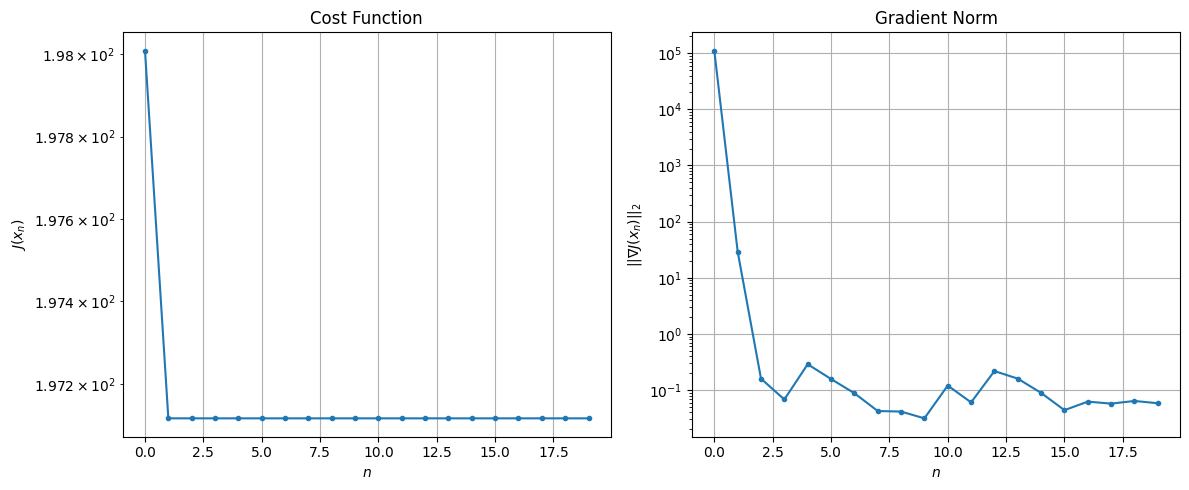


Windows:   5%|▌         | 18/346 [06:07<1:52:16, 20.54s/it]

Before applying the algorithm
Cost function: 197.58413740960688
Gradient norm: 72606.77227744444
Global estimation error: 1892942554.7051954
Position estimation errors: 0.04903833111672502 m, 1.7361406016107366 m, 1.8876192747072233 m, 6.959233376383077 m

Iteration 1
Cost function: 195.6850047816755 (-0.96%)
Gradient norm: 117.07375211700572 (-99.84%)
Global estimation error: 11.174086598456524 (50.66%)
Position estimation errors: 0.03531214028006907 m, 2.3371901119425873 m, 3.565085747047718 m, 10.32891085948796 m

Iteration 2
Cost function: 195.6849312802966 (-0.00%)
Gradient norm: 0.3063413946124556 (-99.74%)
Global estimation error: 11.130296147056244 (-0.39%)
Position estimation errors: 0.03531214261527353 m, 2.339014335036914 m, 3.534654250001205 m, 10.2916086020536 m

Iteration 3
Cost function: 195.68493126964844 (-0.00%)
Gradient norm: 0.008228190234420845 (-97.31%)
Global estimation error: 11.130291947441822 (-0.00%)
Position estimation errors: 0.03531214272217196 m, 2.339014

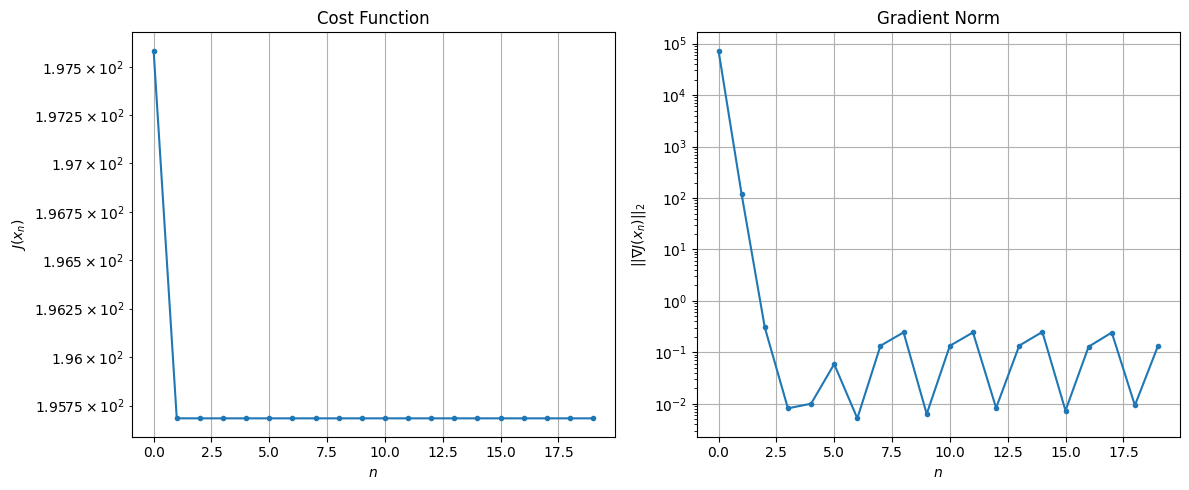


Windows:   5%|▌         | 19/346 [06:28<1:52:28, 20.64s/it]

Before applying the algorithm
Cost function: 205.36611121390962
Gradient norm: 52221.49321395852
Global estimation error: 1893311051.1270068
Position estimation errors: 0.03475389145315993 m, 2.2114245989726147 m, 3.238611144576531 m, 9.458559351109466 m

Iteration 1
Cost function: 202.4117880136099 (-1.44%)
Gradient norm: 45.78414397679909 (-99.91%)
Global estimation error: 7.899261759138864 (-22.85%)
Position estimation errors: 0.05032863566705078 m, 2.7343955303725327 m, 2.547205321556915 m, 6.959201914681619 m

Iteration 2
Cost function: 202.41177546328768 (-0.00%)
Gradient norm: 0.03111825133547477 (-99.93%)
Global estimation error: 7.890507506078895 (-0.11%)
Position estimation errors: 0.05032863647692195 m, 2.7366652037695105 m, 2.5436665376369016 m, 6.949666313626487 m

Iteration 3
Cost function: 202.41177545837598 (-0.00%)
Gradient norm: 0.046248235770146 (48.62%)
Global estimation error: 7.89050709238633 (-0.00%)
Position estimation errors: 0.05032863549592006 m, 2.7366652530

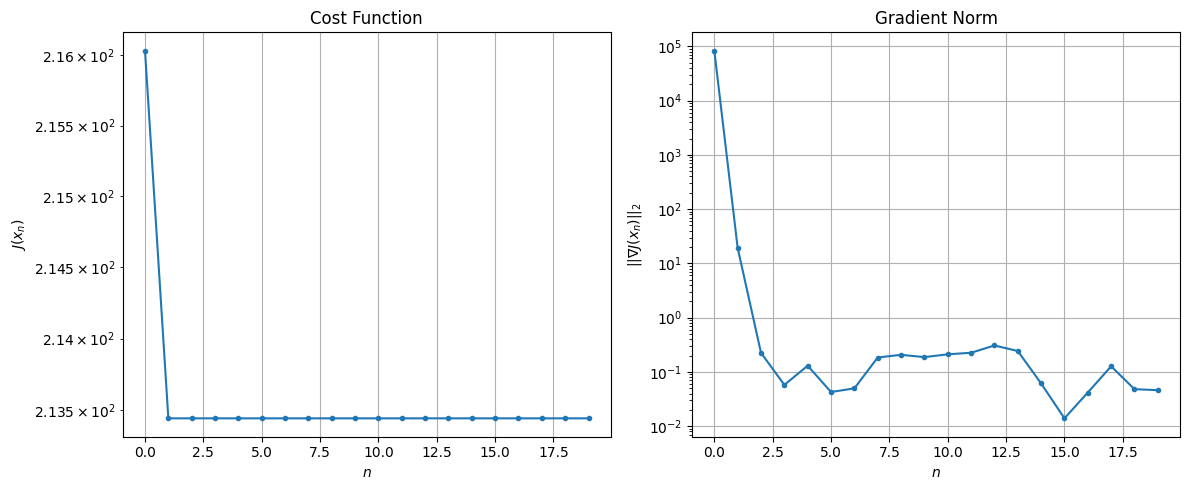


Windows:   7%|▋         | 24/346 [08:12<1:51:48, 20.83s/it]

Before applying the algorithm
Cost function: 217.96885575555484
Gradient norm: 260912.5778861583
Global estimation error: 1895629141.7064157
Position estimation errors: 0.02387233386268461 m, 1.5659054304545583 m, 1.2150559997832653 m, 3.1365993218278705 m

Iteration 1
Cost function: 216.70434152577133 (-0.58%)
Gradient norm: 11.411865010173777 (-100.00%)
Global estimation error: 3.809315513555467 (2.66%)
Position estimation errors: 0.015096689545396594 m, 1.585820874069541 m, 1.3224547484895177 m, 3.2010683393266786 m

Iteration 2
Cost function: 216.7043404677875 (-0.00%)
Gradient norm: 0.24152369921887545 (-97.88%)
Global estimation error: 3.80981998796892 (0.01%)
Position estimation errors: 0.015096690146562074 m, 1.586403748399602 m, 1.32470976407563 m, 3.200447438770562 m

Iteration 3
Cost function: 216.70434043696147 (-0.00%)
Gradient norm: 0.19176064463810372 (-20.60%)
Global estimation error: 3.809819988579078 (0.00%)
Position estimation errors: 0.015096690339246242 m, 1.586403

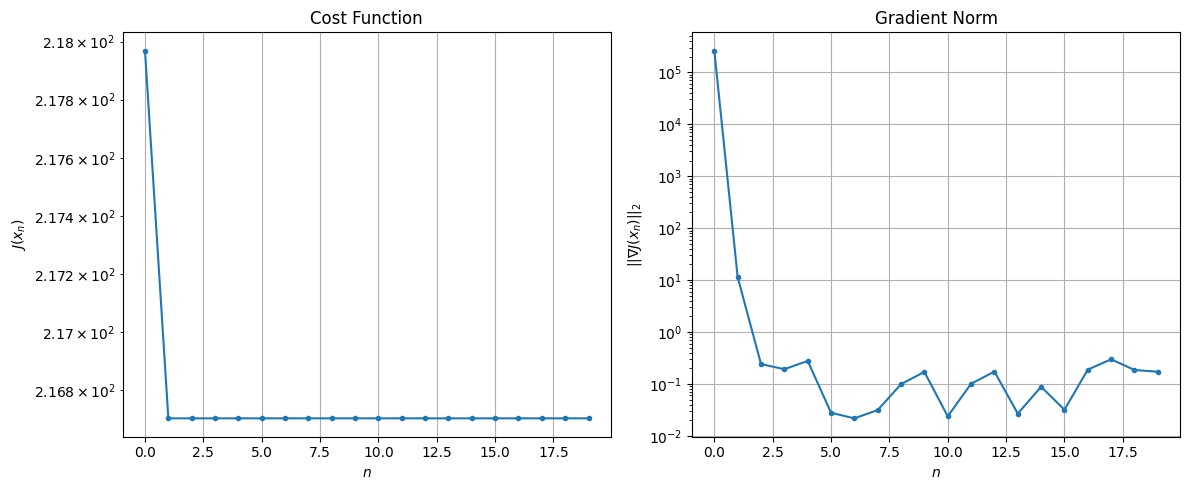


Windows:   7%|▋         | 25/346 [08:30<1:47:26, 20.08s/it]

Before applying the algorithm
Cost function: 220.23617839128804
Gradient norm: 42778.581410140985
Global estimation error: 1896173619.057554
Position estimation errors: 0.014712563013092955 m, 1.4115426041379118 m, 1.242732255359559 m, 3.110668171835543 m

Iteration 1
Cost function: 218.72296725332657 (-0.69%)
Gradient norm: 43.937839455552854 (-99.90%)
Global estimation error: 3.8840837879611425 (6.85%)
Position estimation errors: 0.0127965230794018 m, 1.4972116484259799 m, 1.1233158051066494 m, 3.403282950845552 m

Iteration 2
Cost function: 218.72295718649096 (-0.00%)
Gradient norm: 0.003338087923216935 (-99.99%)
Global estimation error: 3.8779444155030327 (-0.16%)
Position estimation errors: 0.01279652352312427 m, 1.496859446634858 m, 1.115466152624188 m, 3.399015908899674 m

Iteration 3
Cost function: 218.72295719897045 (0.00%)
Gradient norm: 0.01722095732358695 (415.89%)
Global estimation error: 3.87794434574551 (-0.00%)
Position estimation errors: 0.012796524062108256 m, 1.49685

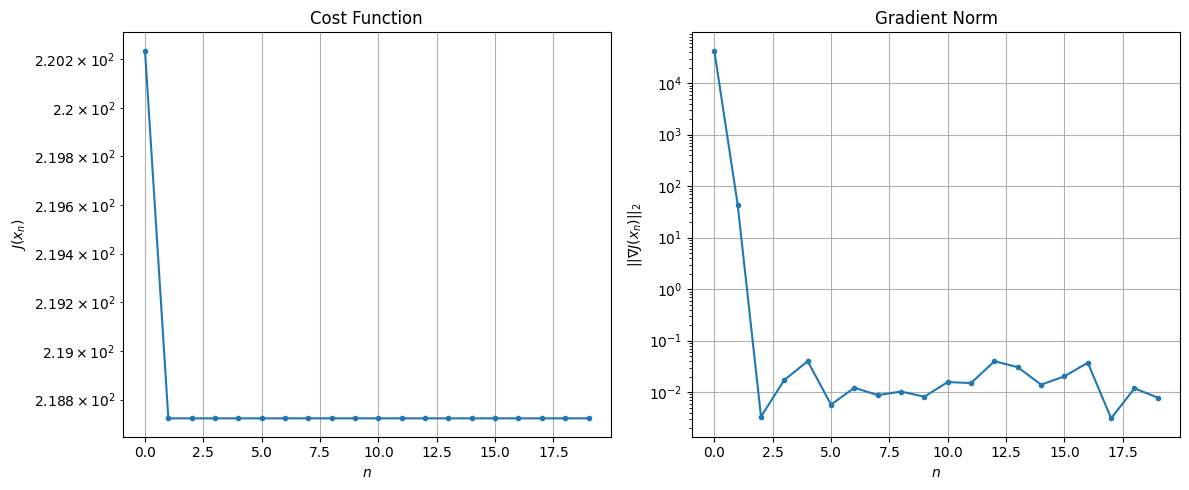


Windows:   8%|▊         | 26/346 [08:51<1:48:47, 20.40s/it]

Before applying the algorithm
Cost function: 218.60683700494323
Gradient norm: 34845.265634906486
Global estimation error: 1896739642.910711
Position estimation errors: 0.012932285610701475 m, 1.401831253269169 m, 0.8215647483336598 m, 3.1178952698236313 m

Iteration 1
Cost function: 218.0386752102363 (-0.26%)
Gradient norm: 4.853495398388635 (-99.99%)
Global estimation error: 3.2238277897342873 (-8.31%)
Position estimation errors: 0.022122639495466813 m, 1.5026585851144256 m, 0.26666189375459765 m, 2.839606176233871 m

Iteration 2
Cost function: 218.03867519602315 (-0.00%)
Gradient norm: 0.10018401549509141 (-97.94%)
Global estimation error: 3.2236151040108183 (-0.01%)
Position estimation errors: 0.022122639007409427 m, 1.5025916593884288 m, 0.26667406780727826 m, 2.8393989858939075 m

Iteration 3
Cost function: 218.03867518697436 (-0.00%)
Gradient norm: 0.06415278047757905 (-35.97%)
Global estimation error: 3.2236151012799565 (-0.00%)
Position estimation errors: 0.022122639089307613 

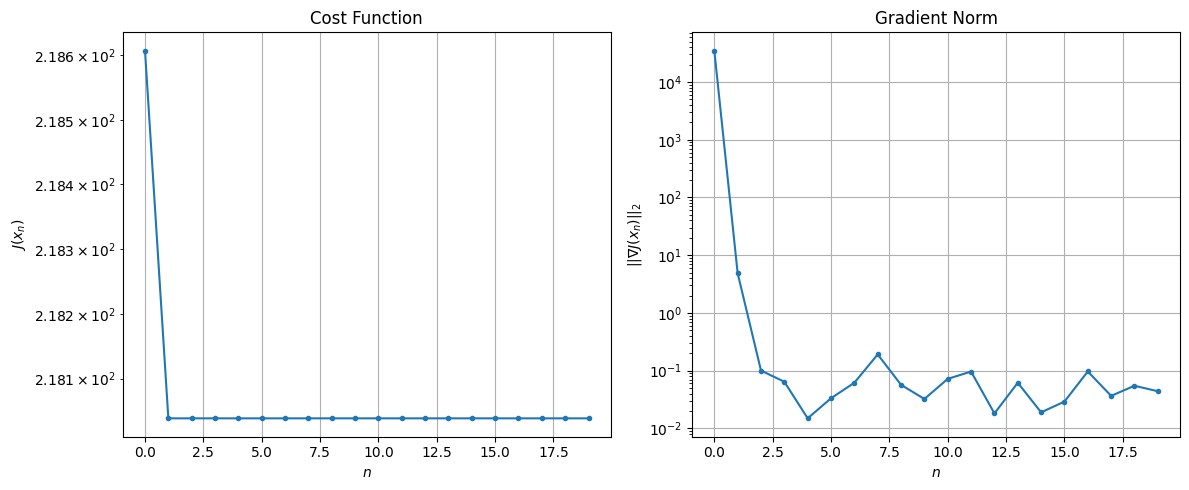


Windows:   8%|▊         | 27/346 [09:12<1:48:55, 20.49s/it]

Before applying the algorithm
Cost function: 219.23157942824236
Gradient norm: 34994.81555386041
Global estimation error: 1897324795.4746451
Position estimation errors: 0.021987587232596473 m, 1.418063562095864 m, 0.34071244655883925 m, 2.8833508313878244 m

Iteration 1
Cost function: 218.44587587324702 (-0.36%)
Gradient norm: 9.523400582409206 (-99.97%)
Global estimation error: 3.790400402312526 (17.30%)
Position estimation errors: 0.013796079681726976 m, 1.4676893511779674 m, 1.4593188316816503 m, 3.1753914077418757 m

Iteration 2
Cost function: 218.44587571551068 (-0.00%)
Gradient norm: 0.05215247407735106 (-99.45%)
Global estimation error: 3.790001494278003 (-0.01%)
Position estimation errors: 0.013796081036922883 m, 1.467473173372019 m, 1.4591328792919267 m, 3.1751006209467696 m

Iteration 3
Cost function: 218.44587569186626 (-0.00%)
Gradient norm: 0.009293112237223455 (-82.18%)
Global estimation error: 3.7900014949690655 (0.00%)
Position estimation errors: 0.013796080388716258 m,

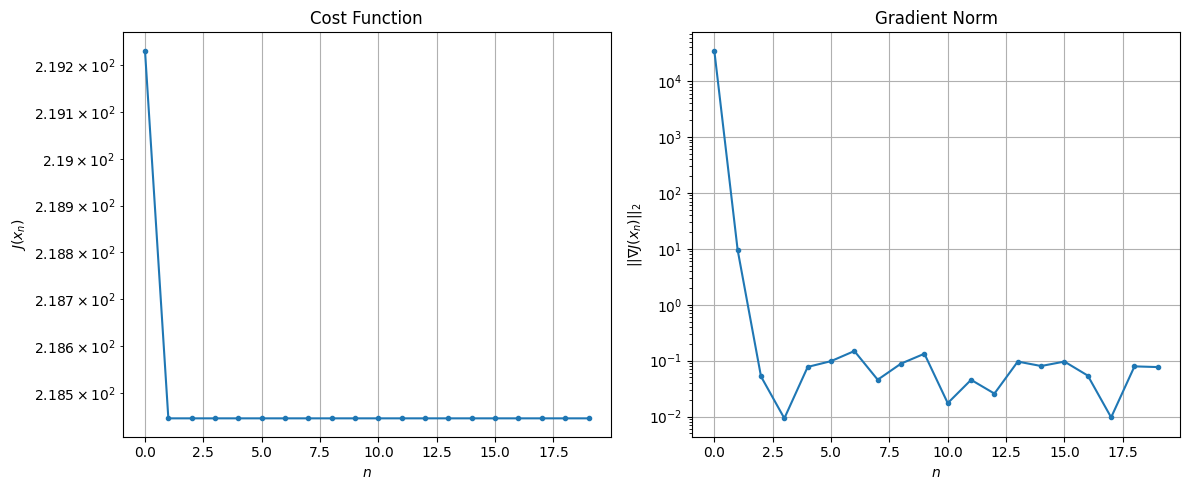


Windows:   8%|▊         | 28/346 [09:33<1:49:13, 20.61s/it]

Before applying the algorithm
Cost function: 221.27681485235235
Gradient norm: 202250.86412243088
Global estimation error: 1897926482.8453476
Position estimation errors: 0.014216511780108916 m, 1.466342016167175 m, 1.7352503703004194 m, 3.510090583471034 m

Iteration 1
Cost function: 220.22749048346859 (-0.47%)
Gradient norm: 24.316619971217925 (-99.99%)
Global estimation error: 5.23166095992201 (25.12%)
Position estimation errors: 0.01824160866251527 m, 1.1695167491529714 m, 2.544133627615699 m, 4.419214738718883 m

Iteration 2
Cost function: 220.22748941159628 (-0.00%)
Gradient norm: 0.041920447705434884 (-99.83%)
Global estimation error: 5.2327626785731844 (0.02%)
Position estimation errors: 0.018241606925342293 m, 1.1693439545216904 m, 2.545085851374944 m, 4.420016496904306 m

Iteration 3
Cost function: 220.22748944446113 (0.00%)
Gradient norm: 0.022299434418708394 (-46.81%)
Global estimation error: 5.232762677897929 (-0.00%)
Position estimation errors: 0.0182416076940462 m, 1.1693

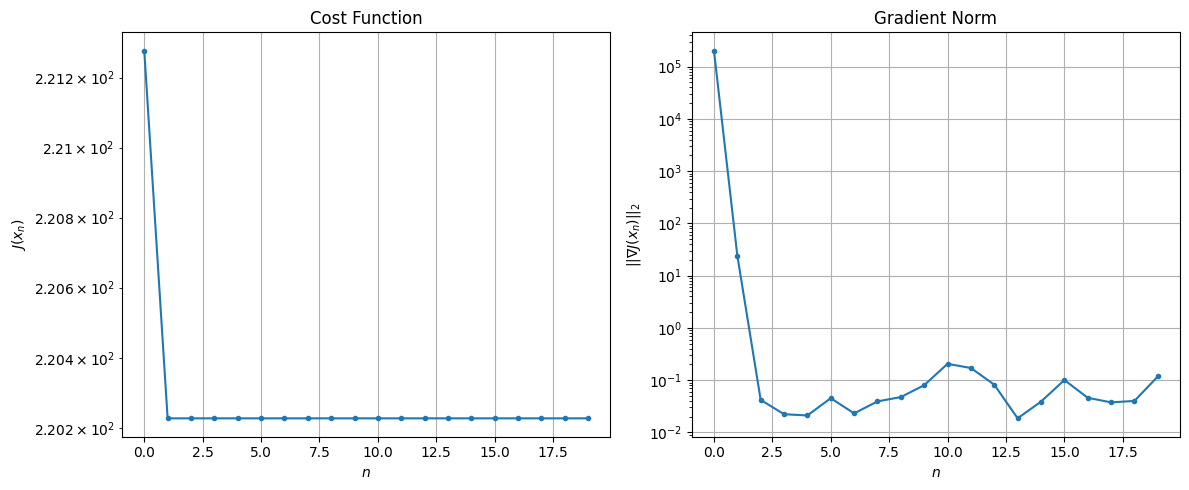


Windows:   8%|▊         | 29/346 [09:54<1:49:41, 20.76s/it]

Before applying the algorithm
Cost function: 221.03654736529646
Gradient norm: 34596.090527763095
Global estimation error: 1898542093.8429656
Position estimation errors: 0.01793754990144998 m, 1.061293610477256 m, 2.7979229996737818 m, 4.8038957744592805 m

Iteration 1
Cost function: 220.31216987438535 (-0.33%)
Gradient norm: 18.128841942703545 (-99.95%)
Global estimation error: 4.839129883740608 (-14.50%)
Position estimation errors: 0.02363133922784193 m, 1.1777783718726786 m, 1.9947775773837415 m, 4.248551701282156 m

Iteration 2
Cost function: 220.31216957562535 (-0.00%)
Gradient norm: 0.13103050385423928 (-99.28%)
Global estimation error: 4.839231169369745 (0.00%)
Position estimation errors: 0.023631339880965805 m, 1.1777855586635684 m, 1.9949042328647182 m, 4.2486056074734595 m

Iteration 3
Cost function: 220.31216952005656 (-0.00%)
Gradient norm: 0.3289484436202485 (151.05%)
Global estimation error: 4.839231170258606 (0.00%)
Position estimation errors: 0.02363134044026153 m, 1.17

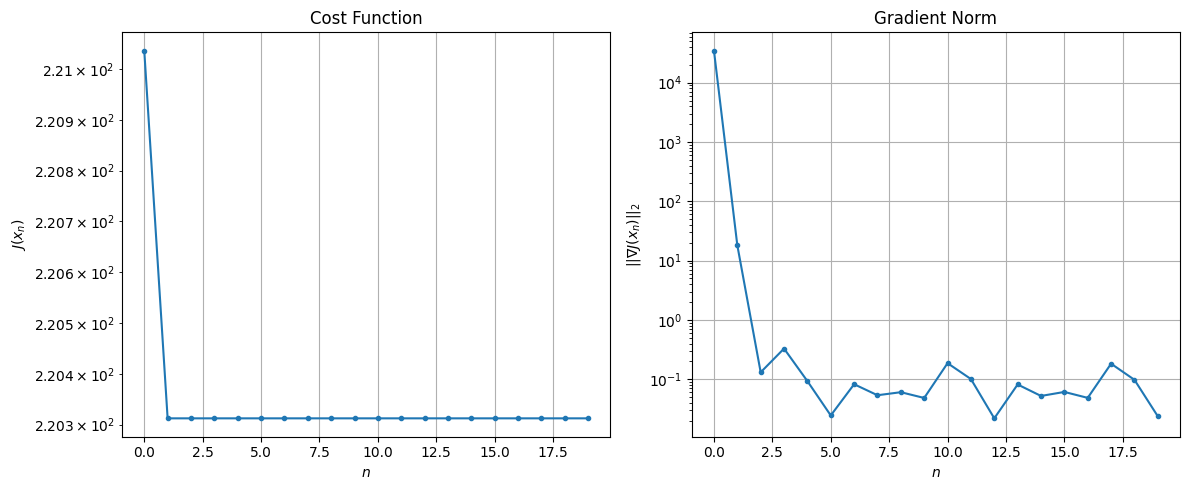


Windows:   9%|▊         | 30/346 [10:12<1:45:02, 19.94s/it]

Before applying the algorithm
Cost function: 223.18562959628295
Gradient norm: 59160.06104131953
Global estimation error: 1899168918.1205916
Position estimation errors: 0.02378006675203968 m, 1.0490340281731765 m, 2.3108105868692856 m, 4.660449091329919 m

Iteration 1
Cost function: 221.06393669170896 (-0.95%)
Gradient norm: 31.755584851504434 (-99.95%)
Global estimation error: 5.4390213238485945 (2.49%)
Position estimation errors: 0.025764937399785914 m, 1.3388525120148307 m, 2.803421134705302 m, 4.464361384436315 m

Iteration 2
Cost function: 221.06393586842933 (-0.00%)
Gradient norm: 0.3213125927507014 (-98.99%)
Global estimation error: 5.440006917558331 (0.02%)
Position estimation errors: 0.025764940936892484 m, 1.338636693822272 m, 2.804251487070502 m, 4.465105420004898 m

Iteration 3
Cost function: 221.06393586931995 (0.00%)
Gradient norm: 0.08445140645304988 (-73.72%)
Global estimation error: 5.440006915007742 (-0.00%)
Position estimation errors: 0.025764939953949146 m, 1.338636

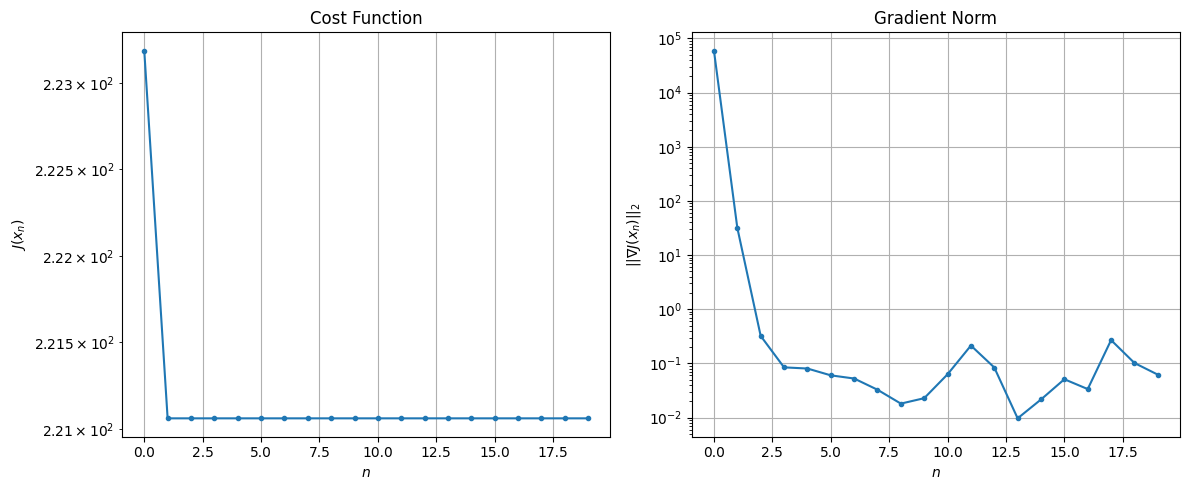


Windows:   9%|▉         | 31/346 [10:33<1:46:22, 20.26s/it]

Before applying the algorithm
Cost function: 222.70712261701547
Gradient norm: 100868.58333846214
Global estimation error: 1899804208.9271784
Position estimation errors: 0.025647509488677837 m, 1.2226613691141885 m, 2.9605183063371805 m, 4.792362895243042 m

Iteration 1
Cost function: 221.76352860885845 (-0.42%)
Gradient norm: 16.62470704704273 (-99.98%)
Global estimation error: 5.170789927750398 (-10.30%)
Position estimation errors: 0.045190987990468154 m, 1.7475080112741246 m, 2.5711768888721047 m, 4.131616030026836 m

Iteration 2
Cost function: 221.7635281008819 (-0.00%)
Gradient norm: 0.28946729857571224 (-98.26%)
Global estimation error: 5.170033452640802 (-0.01%)
Position estimation errors: 0.045190987082229295 m, 1.747600145840359 m, 2.570534426929123 m, 4.131030112863654 m

Iteration 3
Cost function: 221.76352812816398 (0.00%)
Gradient norm: 0.17047598622757404 (-41.11%)
Global estimation error: 5.170033451745154 (-0.00%)
Position estimation errors: 0.045190987082229295 m, 1.74

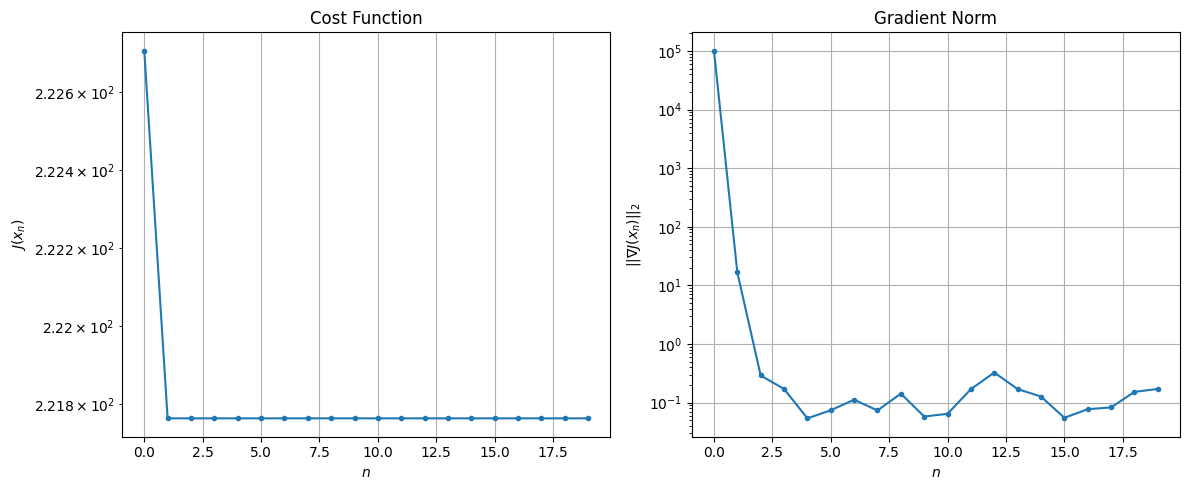


Windows:   9%|▉         | 32/346 [10:56<1:50:03, 21.03s/it]

Before applying the algorithm
Cost function: 225.3554620699441
Gradient norm: 46074.39943296382
Global estimation error: 1900445175.410733
Position estimation errors: 0.04337863923181531 m, 1.7028614261270856 m, 2.6855334736724097 m, 4.374147071073421 m

Iteration 1
Cost function: 224.36611123345463 (-0.44%)
Gradient norm: 17.694706480175938 (-99.96%)
Global estimation error: 4.079932018692223 (-24.56%)
Position estimation errors: 0.05848181121012363 m, 1.5572329945882655 m, 1.7978821182689868 m, 3.3143705082131047 m

Iteration 2
Cost function: 224.366110860026 (-0.00%)
Gradient norm: 0.12260416186662018 (-99.31%)
Global estimation error: 4.080809595534084 (0.02%)
Position estimation errors: 0.05848181213502506 m, 1.5576267098434586 m, 1.7985243003811366 m, 3.314917438290348 m

Iteration 3
Cost function: 224.36611084929015 (-0.00%)
Gradient norm: 0.05490721807584281 (-55.22%)
Global estimation error: 4.0808095970646034 (0.00%)
Position estimation errors: 0.05848181233992063 m, 1.557626

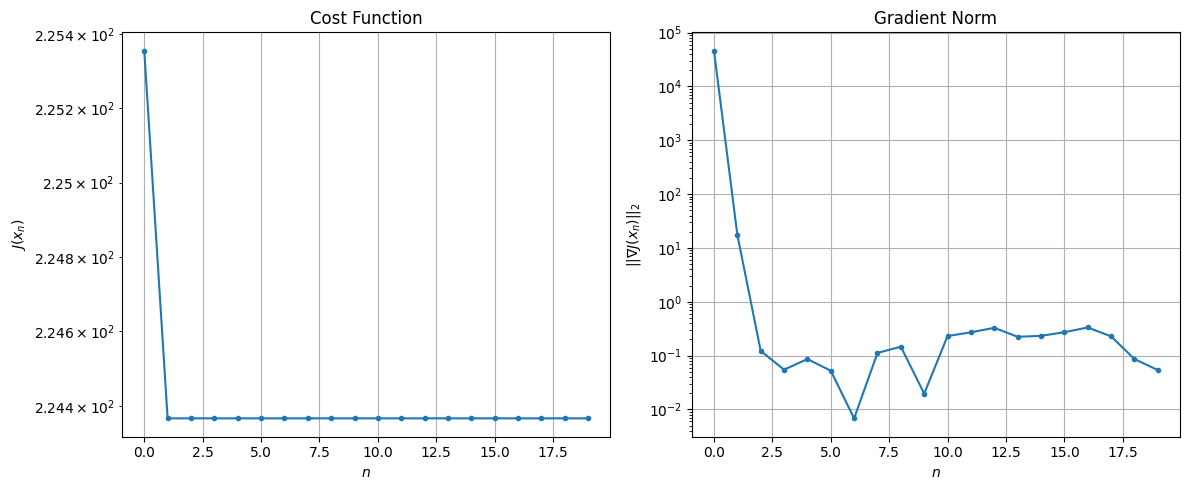


Windows:  10%|▉         | 33/346 [11:17<1:49:48, 21.05s/it]

Before applying the algorithm
Cost function: 223.83592241886322
Gradient norm: 117858.1136408154
Global estimation error: 1901089055.75821
Position estimation errors: 0.05547139170489104 m, 1.5110871150220684 m, 1.8595928426353134 m, 3.4447102319038483 m

Iteration 1
Cost function: 222.81014387557528 (-0.46%)
Gradient norm: 20.97312481718054 (-99.98%)
Global estimation error: 4.803400492793871 (14.46%)
Position estimation errors: 0.038111303152086565 m, 1.3866245075480057 m, 2.3724629822690395 m, 3.9395282392846465 m

Iteration 2
Cost function: 222.81014330051667 (-0.00%)
Gradient norm: 0.020514057270335503 (-99.90%)
Global estimation error: 4.802984065757109 (-0.01%)
Position estimation errors: 0.0381113038625303 m, 1.3869116143400313 m, 2.3720573719482196 m, 3.939163682860916 m

Iteration 3
Cost function: 222.8101432917043 (-0.00%)
Gradient norm: 0.02686312962003848 (30.95%)
Global estimation error: 4.802984066754604 (0.00%)
Position estimation errors: 0.03811130371968399 m, 1.386911

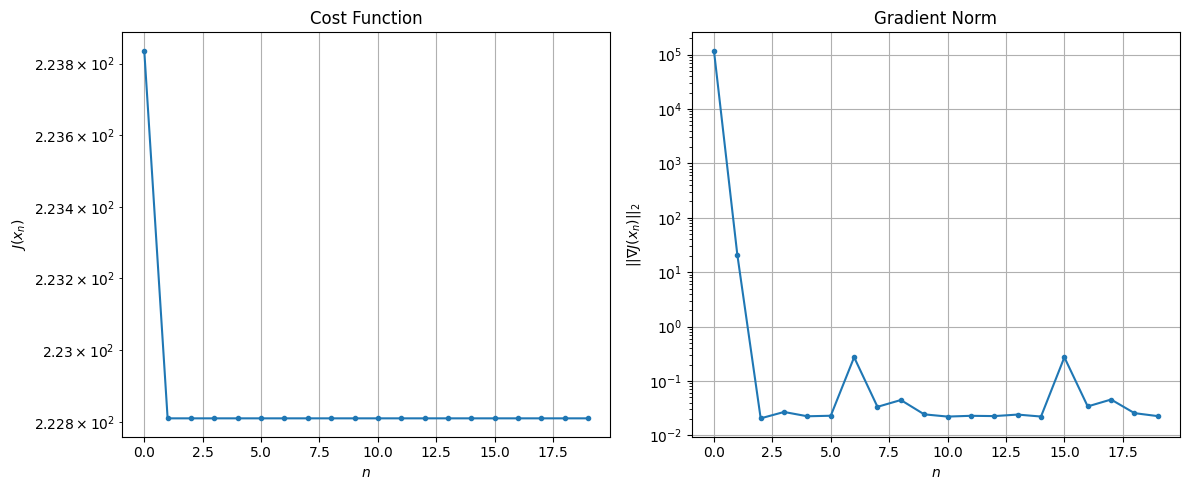


Windows:  10%|▉         | 34/346 [11:38<1:50:15, 21.20s/it]

Before applying the algorithm
Cost function: 225.39892553453203
Gradient norm: 167509.3608897112
Global estimation error: 1901733074.5218334
Position estimation errors: 0.03626607542554549 m, 1.2776347009154636 m, 2.3908689148459406 m, 3.927801686699633 m

Iteration 1
Cost function: 224.374368192084 (-0.45%)
Gradient norm: 11.845487003448 (-99.99%)
Global estimation error: 3.7900707696551184 (-20.59%)
Position estimation errors: 0.03016015390496732 m, 1.2408871996852766 m, 1.4792899977342129 m, 3.2612293863959736 m

Iteration 2
Cost function: 224.37436804237987 (-0.00%)
Gradient norm: 0.3373720656738369 (-97.15%)
Global estimation error: 3.791066065713579 (0.03%)
Position estimation errors: 0.030160153410425453 m, 1.2409852253105518 m, 1.4800799102117075 m, 3.2619904433208196 m

Iteration 3
Cost function: 224.37436794917022 (-0.00%)
Gradient norm: 0.21063656587887158 (-37.57%)
Global estimation error: 3.791066069106307 (0.00%)
Position estimation errors: 0.03016015371166132 m, 1.240985

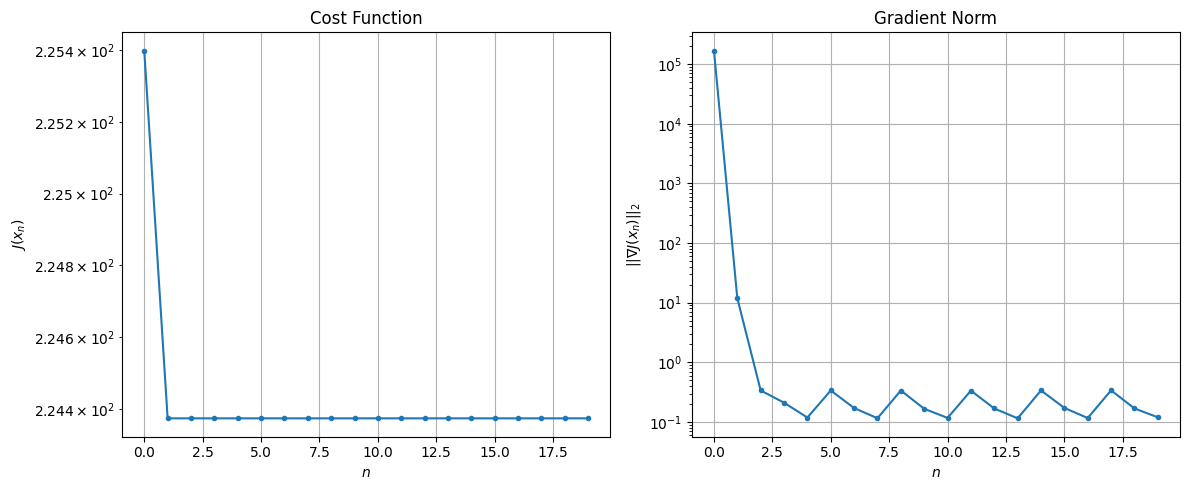


Windows:  10%|█         | 35/346 [11:58<1:47:26, 20.73s/it]

Before applying the algorithm
Cost function: 225.24489202354027
Gradient norm: 76297.36632344165
Global estimation error: 1902374354.2289293
Position estimation errors: 0.02897509069854849 m, 1.1648041174845536 m, 1.5689778597367574 m, 3.2954932877359204 m

Iteration 1
Cost function: 223.63352347092692 (-0.72%)
Gradient norm: 7.990848357283793 (-99.99%)
Global estimation error: 3.4826064568557684 (-9.10%)
Position estimation errors: 0.024434067807992448 m, 1.4302784948614546 m, 0.9373438253398447 m, 3.033748432476785 m

Iteration 2
Cost function: 223.6335232467619 (-0.00%)
Gradient norm: 0.08613577670579502 (-98.92%)
Global estimation error: 3.4827296545809845 (0.00%)
Position estimation errors: 0.024434066748221534 m, 1.4310857972264959 m, 0.9371130808529844 m, 3.03358042617366 m

Iteration 3
Cost function: 223.63352318746595 (-0.00%)
Gradient norm: 0.010013256843252246 (-88.38%)
Global estimation error: 3.482729653500669 (-0.00%)
Position estimation errors: 0.024434066928294466 m, 1.

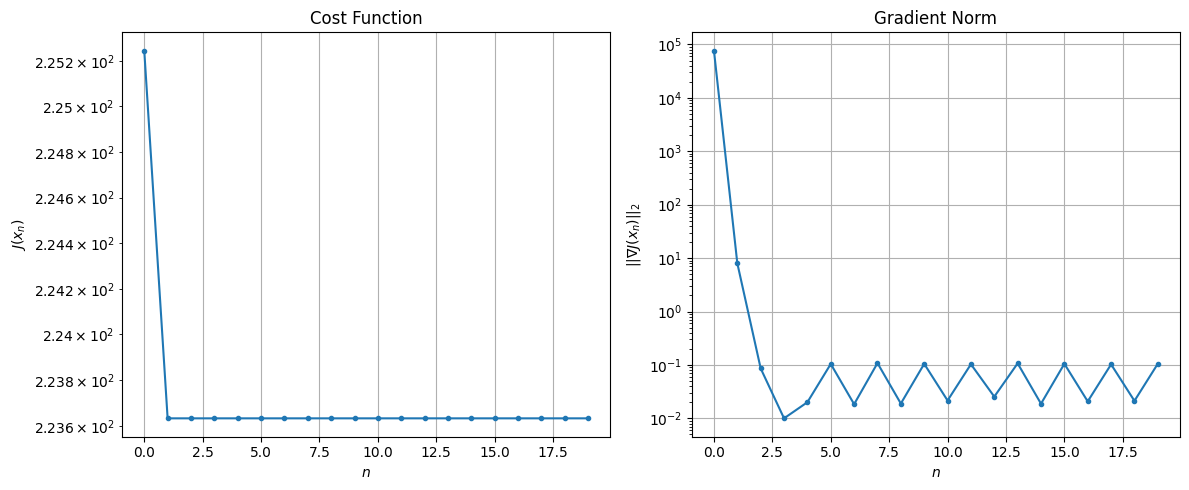


Windows:  10%|█         | 36/346 [12:20<1:49:02, 21.10s/it]

Before applying the algorithm
Cost function: 225.60586664997513
Gradient norm: 48752.4881226311
Global estimation error: 1903010160.6795182
Position estimation errors: 0.0228714156583609 m, 1.3822413989182756 m, 1.0362181673302124 m, 3.0870013589421204 m

Iteration 1
Cost function: 224.12997525514436 (-0.65%)
Gradient norm: 55.071890155535414 (-99.89%)
Global estimation error: 3.7624657868610165 (6.36%)
Position estimation errors: 0.034042500383288286 m, 1.570882960675623 m, 1.1826659761543816 m, 3.2075856554147335 m

Iteration 2
Cost function: 224.1299735092199 (-0.00%)
Gradient norm: 0.10306117487902076 (-99.81%)
Global estimation error: 3.7628681821215353 (0.01%)
Position estimation errors: 0.034042499434892175 m, 1.5713835550305868 m, 1.1826626406110994 m, 3.2078137058478666 m

Iteration 3
Cost function: 224.12997351081572 (0.00%)
Gradient norm: 0.09550283262465359 (-7.33%)
Global estimation error: 3.762868174367315 (-0.00%)
Position estimation errors: 0.03404250035470927 m, 1.5713

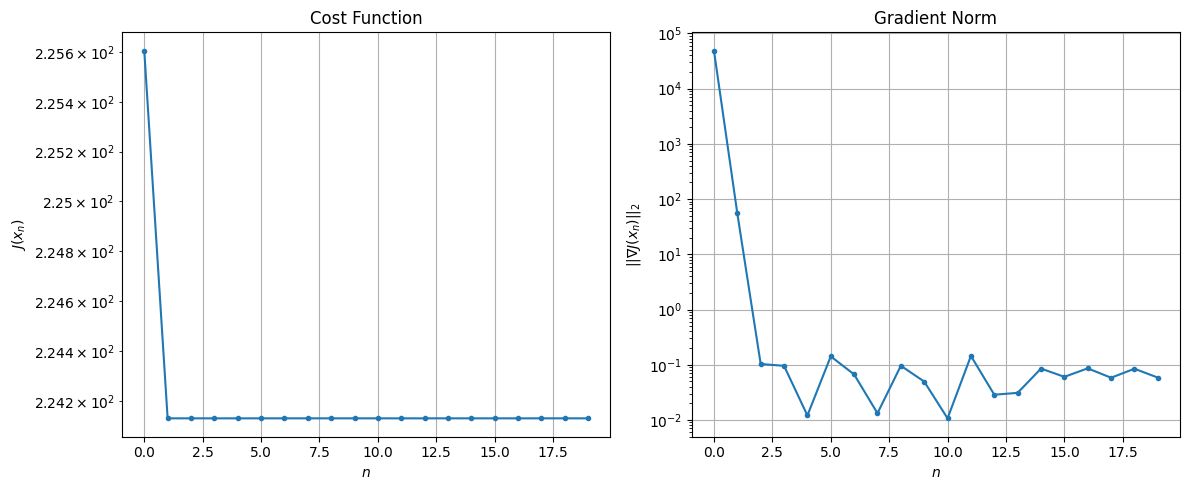


Windows:  11%|█         | 37/346 [12:42<1:49:44, 21.31s/it]

Before applying the algorithm
Cost function: 223.04474657322348
Gradient norm: 36626.529255457215
Global estimation error: 1903637745.7344317
Position estimation errors: 0.031173887123595447 m, 1.552939090069055 m, 1.1759674206154174 m, 3.023790963525982 m

Iteration 1
Cost function: 221.80344913356228 (-0.56%)
Gradient norm: 14.827520538055301 (-99.96%)
Global estimation error: 2.6068012144294688 (-27.53%)
Position estimation errors: 0.05858058286322257 m, 1.6079284481410319 m, 0.3638377763870154 m, 2.01845384523406 m

Iteration 2
Cost function: 221.8034488931291 (-0.00%)
Gradient norm: 0.06432312389090816 (-99.57%)
Global estimation error: 2.6073828972986597 (0.02%)
Position estimation errors: 0.0585805839624792 m, 1.6079339238189536 m, 0.3643292259422388 m, 2.01911204804708 m

Iteration 3
Cost function: 221.80344889695857 (0.00%)
Gradient norm: 0.09117625023025139 (41.75%)
Global estimation error: 2.607382898555931 (0.00%)
Position estimation errors: 0.05858058403785361 m, 1.6079339

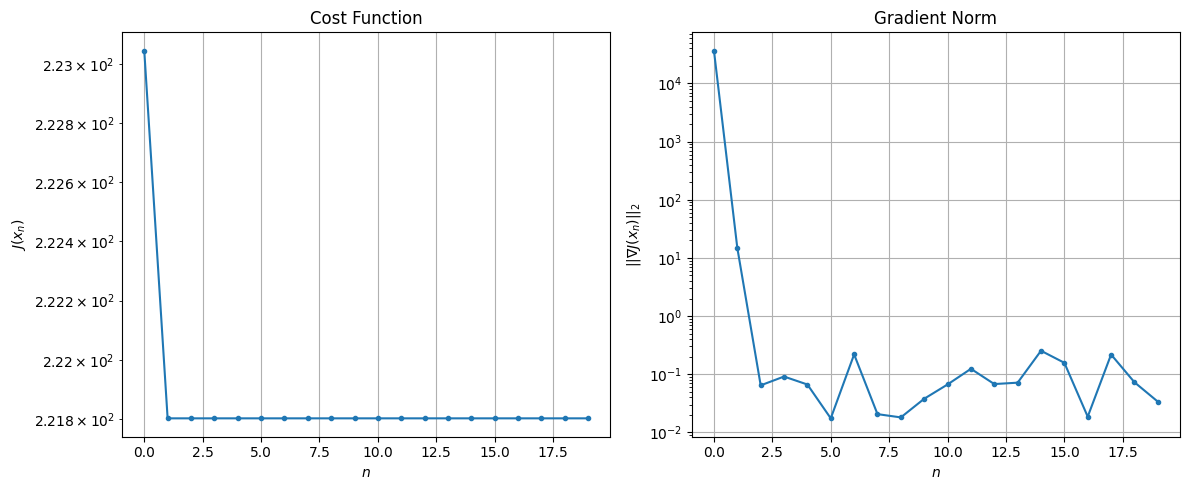


Windows:  11%|█         | 38/346 [13:01<1:46:48, 20.81s/it]

Before applying the algorithm
Cost function: 225.6799220363911
Gradient norm: 62258.00796342872
Global estimation error: 1904254354.7294009
Position estimation errors: 0.05371410945277989 m, 1.5663808471693423 m, 0.39160094013612984 m, 1.8180924318716405 m

Iteration 1
Cost function: 224.42097190884826 (-0.56%)
Gradient norm: 17.506633736731366 (-99.97%)
Global estimation error: 1.9899899156377125 (-18.18%)
Position estimation errors: 0.046237810694514485 m, 0.820592626120776 m, 0.6841692547202713 m, 1.678224528823508 m

Iteration 2
Cost function: 224.42097159606945 (-0.00%)
Gradient norm: 0.054980081149684217 (-99.69%)
Global estimation error: 1.9901672290018906 (0.01%)
Position estimation errors: 0.04623781016472307 m, 0.8214345918457238 m, 0.6839942376780787 m, 1.6780942236091605 m

Iteration 3
Cost function: 224.4209715695345 (-0.00%)
Gradient norm: 0.083354096792128 (51.61%)
Global estimation error: 1.9901672301462663 (0.00%)
Position estimation errors: 0.04623781008400498 m, 0.82

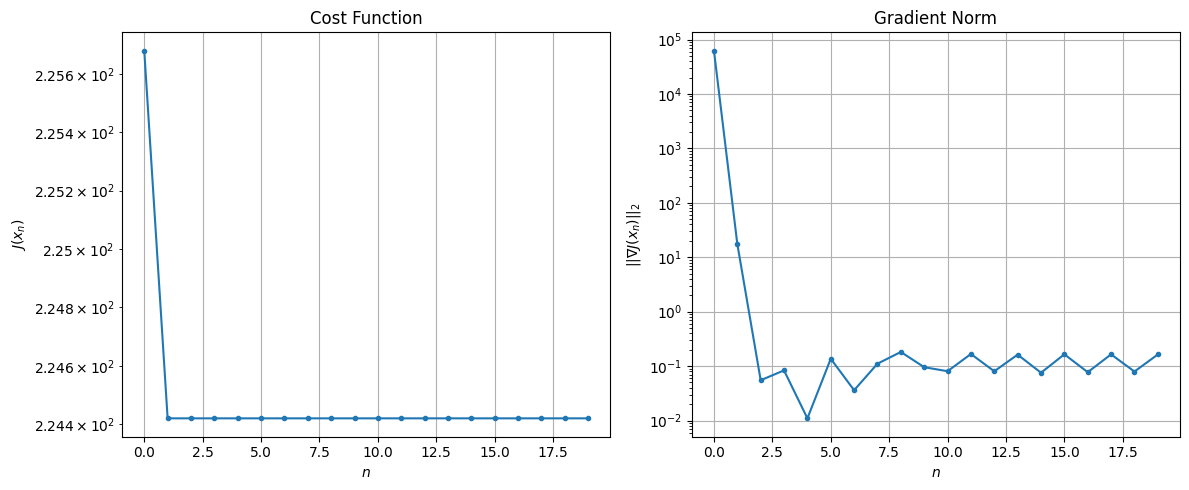


Windows:  11%|█▏        | 39/346 [13:20<1:43:12, 20.17s/it]

Before applying the algorithm
Cost function: 231.34776135556316
Gradient norm: 64969.96738907944
Global estimation error: 1904857413.9544802
Position estimation errors: 0.04279721401660501 m, 0.7810082094046518 m, 0.6672517578011549 m, 1.3948465250616684 m

Iteration 1
Cost function: 229.47712107145617 (-0.81%)
Gradient norm: 53.94257686532055 (-99.92%)
Global estimation error: 1.4223485418648503 (-17.92%)
Position estimation errors: 0.05150131433550502 m, 1.358496925433379 m, 0.2671990947564517 m, 0.3217272425719508 m

Iteration 2
Cost function: 229.47711956339404 (-0.00%)
Gradient norm: 0.049617646111901476 (-99.91%)
Global estimation error: 1.4220012988018218 (-0.02%)
Position estimation errors: 0.051501315675259965 m, 1.358407100280329 m, 0.2665296461323795 m, 0.32112627036865815 m

Iteration 3
Cost function: 229.47711946071468 (-0.00%)
Gradient norm: 0.04668354510726111 (-5.91%)
Global estimation error: 1.4220012970129647 (-0.00%)
Position estimation errors: 0.05150131616082522 m,

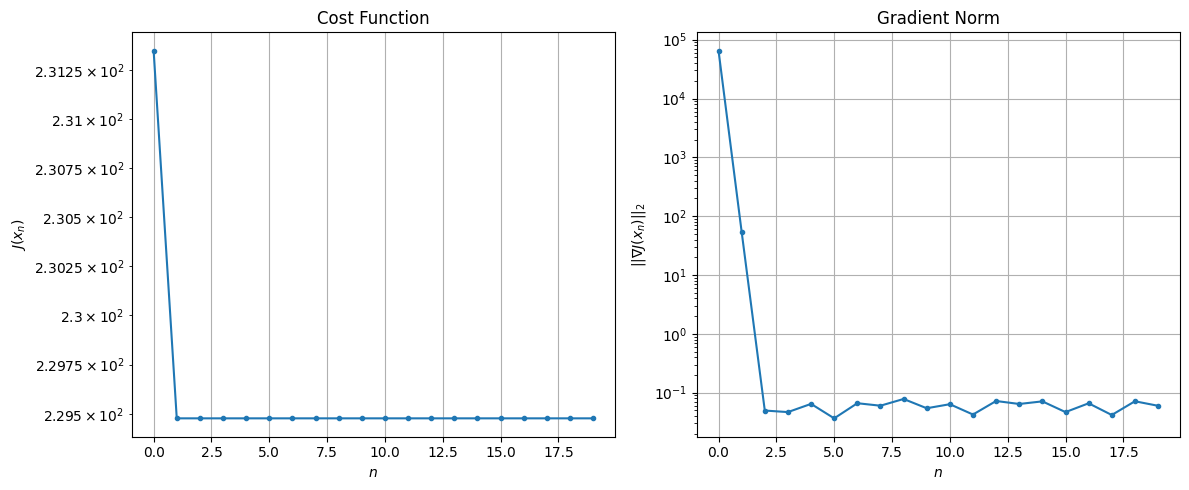


Windows:  12%|█▏        | 40/346 [13:38<1:39:50, 19.58s/it]

Before applying the algorithm
Cost function: 227.33338547324783
Gradient norm: 52776.06290409645
Global estimation error: 1905444213.4285038
Position estimation errors: 0.0477972122975918 m, 1.3153444810352826 m, 0.31342954753676433 m, 0.2871223535816296 m

Iteration 1
Cost function: 226.33244055656016 (-0.44%)
Gradient norm: 10.494962266365466 (-99.98%)
Global estimation error: 1.8911986736502355 (36.73%)
Position estimation errors: 0.042372064857302036 m, 1.6151458062043373 m, 0.6046680512171685 m, 0.7749277690010851 m

Iteration 2
Cost function: 226.33244057063317 (0.00%)
Gradient norm: 0.07521792269354965 (-99.28%)
Global estimation error: 1.891311387477079 (0.01%)
Position estimation errors: 0.04237206465993641 m, 1.6153204204919434 m, 0.604595693686275 m, 0.7748953483599361 m

Iteration 3
Cost function: 226.33244055694888 (-0.00%)
Gradient norm: 0.06949950058651463 (-7.60%)
Global estimation error: 1.8913113859415502 (-0.00%)
Position estimation errors: 0.04237206420596507 m, 1.6

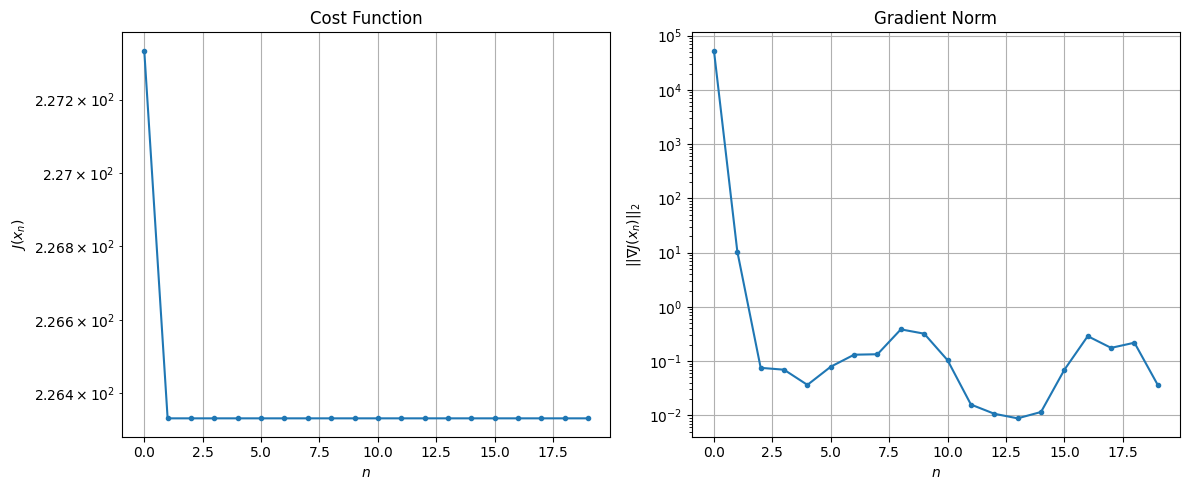


Windows:  12%|█▏        | 41/346 [13:59<1:41:24, 19.95s/it]

Before applying the algorithm
Cost function: 224.98516359158927
Gradient norm: 110393.32115578884
Global estimation error: 1906012258.640096
Position estimation errors: 0.03945149295086621 m, 1.5606595372875385 m, 0.6461370842728249 m, 0.8550280381198507 m

Iteration 1
Cost function: 224.30244401050956 (-0.30%)
Gradient norm: 10.240216245639663 (-99.99%)
Global estimation error: 1.9039783987478731 (0.55%)
Position estimation errors: 0.04910521145726591 m, 1.5260929455093517 m, 0.606789409485103 m, 0.9620594679509756 m

Iteration 2
Cost function: 224.3024438688948 (-0.00%)
Gradient norm: 0.049822971071222605 (-99.51%)
Global estimation error: 1.9037132780410408 (-0.01%)
Position estimation errors: 0.049105210252165556 m, 1.5257857776779895 m, 0.6068555703874701 m, 0.9619802827887644 m

Iteration 3
Cost function: 224.3024439118488 (0.00%)
Gradient norm: 0.06454272151321569 (29.54%)
Global estimation error: 1.9037132794242757 (0.00%)
Position estimation errors: 0.04910521103920993 m, 1.52

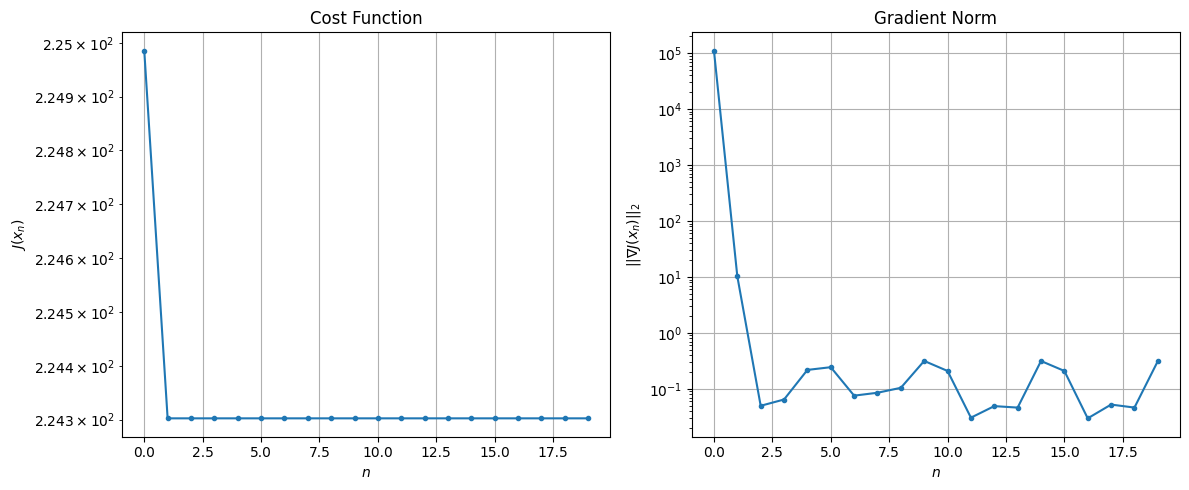


Windows:  12%|█▏        | 42/346 [14:20<1:42:05, 20.15s/it]

Before applying the algorithm
Cost function: 223.57274768837692
Gradient norm: 56811.78875544915
Global estimation error: 1906559106.5251262
Position estimation errors: 0.04541529269778385 m, 1.4873113401674218 m, 0.6212479562994966 m, 1.1494304853998203 m

Iteration 1
Cost function: 222.4629060595651 (-0.50%)
Gradient norm: 52.17003380939232 (-99.91%)
Global estimation error: 2.3151164825415322 (16.91%)
Position estimation errors: 0.04709038524095852 m, 1.0396709217221105 m, 1.2950070232207749 m, 1.6123224344854605 m

Iteration 2
Cost function: 222.4629047373121 (-0.00%)
Gradient norm: 0.10955467717053922 (-99.79%)
Global estimation error: 2.313818507911314 (-0.06%)
Position estimation errors: 0.047090386919846 m, 1.0391479728325892 m, 1.2950412993462208 m, 1.6107680563995441 m

Iteration 3
Cost function: 222.46290476197615 (0.00%)
Gradient norm: 0.41539783724535234 (279.17%)
Global estimation error: 2.31381850168134 (-0.00%)
Position estimation errors: 0.047090386397770176 m, 1.03914

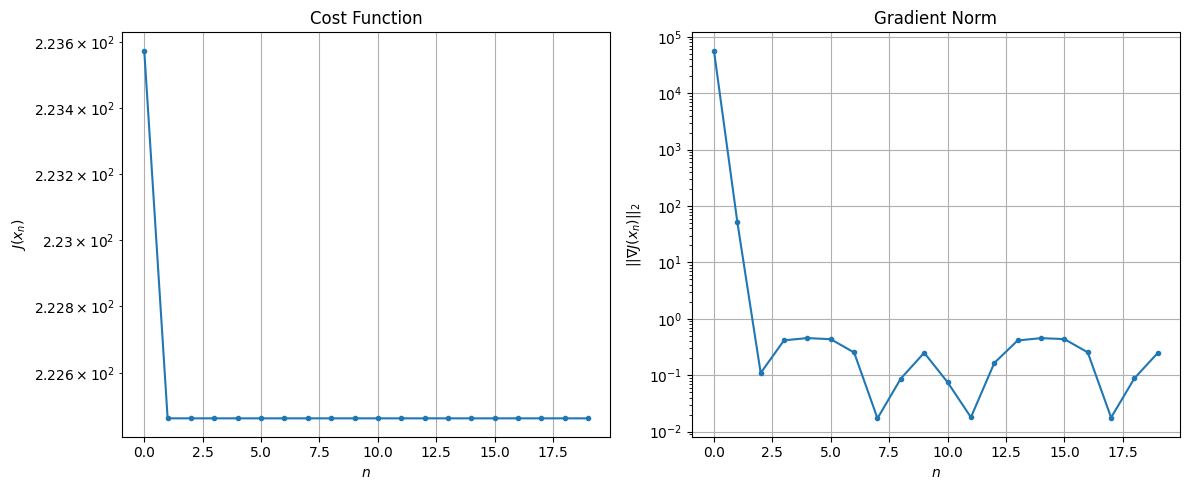


Windows:  12%|█▏        | 43/346 [14:38<1:39:06, 19.63s/it]

Before applying the algorithm
Cost function: 221.39495401445075
Gradient norm: 107070.65392460262
Global estimation error: 1907082397.4039128
Position estimation errors: 0.043532299892271635 m, 0.96036642524353 m, 1.351776137227695 m, 1.6078768504020444 m

Iteration 1
Cost function: 219.91009439691453 (-0.67%)
Gradient norm: 35.41650054692353 (-99.97%)
Global estimation error: 3.3211019755740967 (43.76%)
Position estimation errors: 0.05546077637900179 m, 0.9905790877724667 m, 2.043968720679018 m, 2.422307585365734 m

Iteration 2
Cost function: 219.91009403405675 (-0.00%)
Gradient norm: 0.07635534531110899 (-99.78%)
Global estimation error: 3.320819819331274 (-0.01%)
Position estimation errors: 0.05546077723595372 m, 0.9903872030224244 m, 2.043965884495138 m, 2.4220015878373937 m

Iteration 3
Cost function: 219.91009399343753 (-0.00%)
Gradient norm: 0.2122908047555301 (178.03%)
Global estimation error: 3.3208198137958456 (-0.00%)
Position estimation errors: 0.055460776497385025 m, 0.990

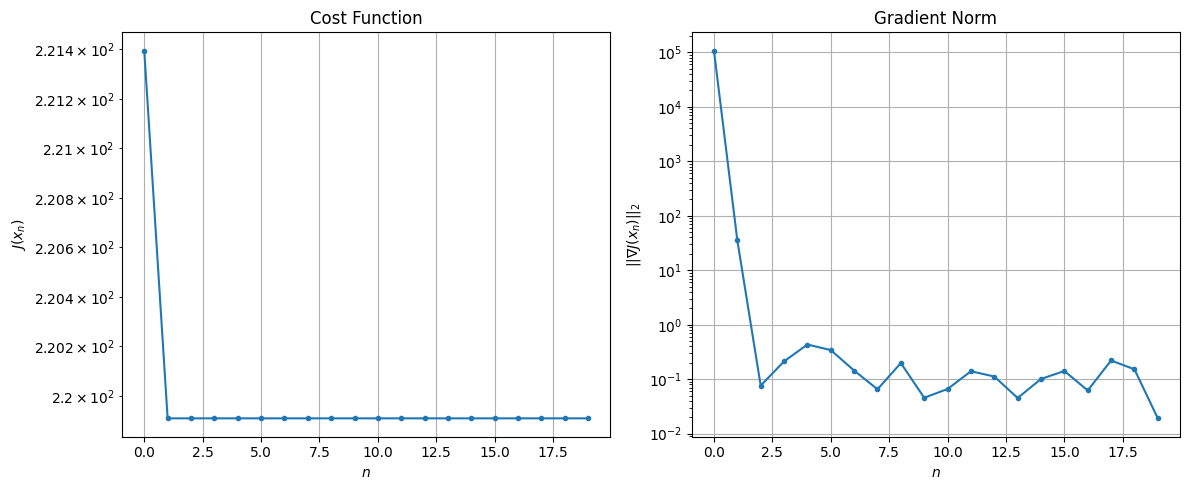


Windows:  13%|█▎        | 44/346 [14:58<1:38:32, 19.58s/it]

Before applying the algorithm
Cost function: 226.52639526480502
Gradient norm: 102777.710342718
Global estimation error: 1907579887.0140946
Position estimation errors: 0.05132841429543055 m, 0.898212567393257 m, 2.071505517946652 m, 2.2766303546733018 m

Iteration 1
Cost function: 223.66842575997904 (-1.26%)
Gradient norm: 101.37632358676956 (-99.90%)
Global estimation error: 5.09587365335868 (58.91%)
Position estimation errors: 0.0335227674956613 m, 1.8114418634110008 m, 1.055614594353158 m, 4.644473598606399 m

Iteration 2
Cost function: 223.66842211002088 (-0.00%)
Gradient norm: 0.11936697284386222 (-99.88%)
Global estimation error: 5.099505257242751 (0.07%)
Position estimation errors: 0.0335227654757967 m, 1.8137566055955514 m, 1.054569832032022 m, 4.647792360976386 m

Iteration 3
Cost function: 223.66842190547607 (-0.00%)
Gradient norm: 0.30493271518797205 (155.46%)
Global estimation error: 5.09950528382803 (0.00%)
Position estimation errors: 0.0335227647099586 m, 1.81375661734910

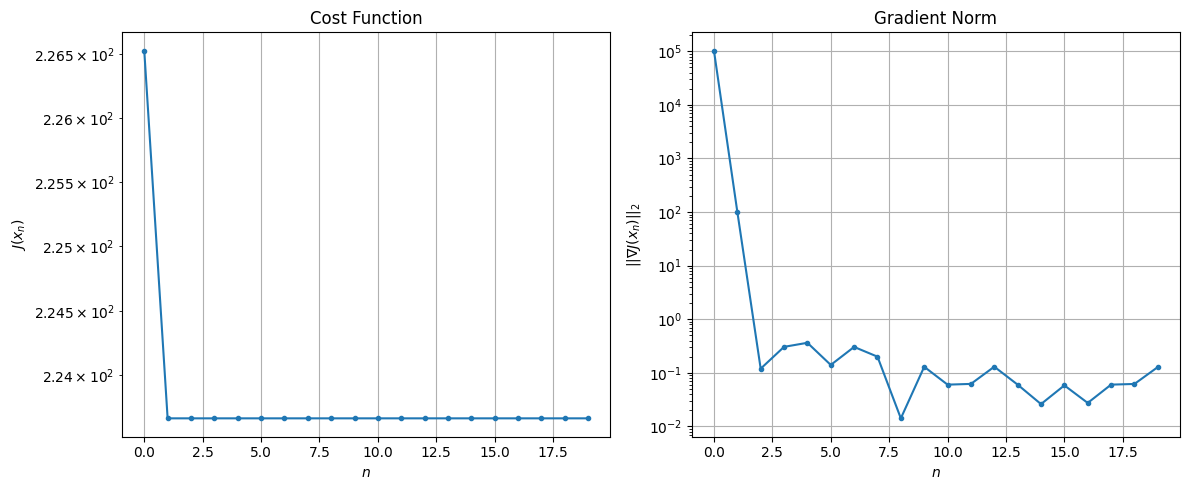


Windows:  13%|█▎        | 45/346 [15:16<1:35:44, 19.08s/it]

Before applying the algorithm
Cost function: 220.77617133349298
Gradient norm: 69790.87492360357
Global estimation error: 1908049358.0112312
Position estimation errors: 0.030302228827011564 m, 1.6995892992533583 m, 1.1027013094695 m, 4.388184522394468 m

Iteration 1
Cost function: 218.5778013354507 (-1.00%)
Gradient norm: 342.3920926758647 (-99.51%)
Global estimation error: 2.008818258311165 (-58.44%)
Position estimation errors: 0.02965145196941388 m, 0.9631438502849337 m, 1.3576348723247385 m, 1.1241201010154707 m

Iteration 2
Cost function: 218.57775209828304 (-0.00%)
Gradient norm: 0.11857948132010629 (-99.97%)
Global estimation error: 1.997241435484357 (-0.58%)
Position estimation errors: 0.029651448328234898 m, 0.9607047182352783 m, 1.3601201161700986 m, 1.1023641829543809 m

Iteration 3
Cost function: 218.57775201355824 (-0.00%)
Gradient norm: 0.03561998795303216 (-69.96%)
Global estimation error: 1.99724083867021 (-0.00%)
Position estimation errors: 0.02965144555136324 m, 0.9607

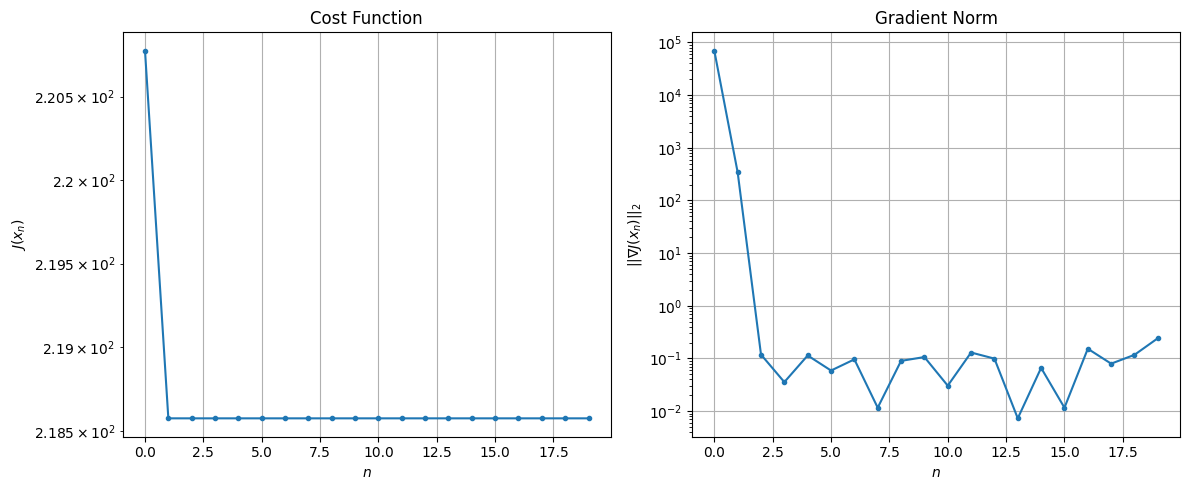


Windows:  13%|█▎        | 46/346 [15:37<1:38:34, 19.72s/it]

Before applying the algorithm
Cost function: 211.8958729951274
Gradient norm: 119580.75859481408
Global estimation error: 1908488878.131464
Position estimation errors: 0.026973494242637005 m, 0.8825355204987627 m, 1.2578307830617996 m, 1.0983916794810071 m

Iteration 1
Cost function: 210.15247223316686 (-0.82%)
Gradient norm: 39.66455950774367 (-99.97%)
Global estimation error: 2.441550614040989 (29.25%)
Position estimation errors: 0.024765232166769437 m, 0.9353466030635174 m, 2.0675131679740373 m, 0.9005828124411971 m

Iteration 2
Cost function: 210.15246864824618 (-0.00%)
Gradient norm: 0.5605948594497213 (-98.59%)
Global estimation error: 2.4396330848658914 (-0.08%)
Position estimation errors: 0.024765236759119885 m, 0.9357508062496099 m, 2.066862545613712 m, 0.8964503377526537 m

Iteration 3
Cost function: 210.1524685175433 (-0.00%)
Gradient norm: 0.34966393888991787 (-37.63%)
Global estimation error: 2.439633085829348 (0.00%)
Position estimation errors: 0.024765234752090262 m, 0.9

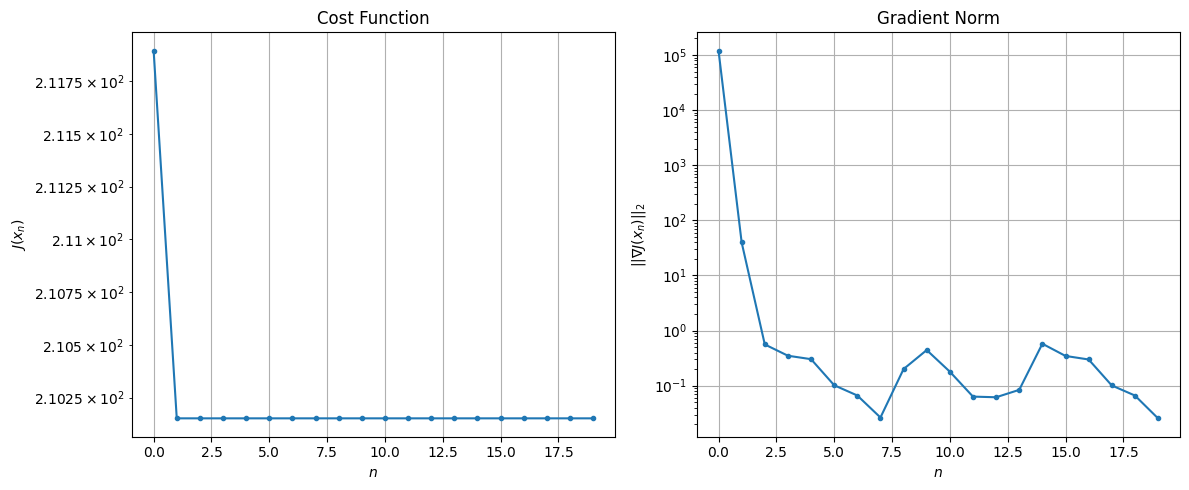


Windows:  14%|█▎        | 47/346 [15:57<1:39:46, 20.02s/it]

Before applying the algorithm
Cost function: 211.00969244462402
Gradient norm: 158100.80271605885
Global estimation error: 1908896512.1048672
Position estimation errors: 0.022988309831369617 m, 0.8719693580534901 m, 2.0131075958210207 m, 1.008716976383438 m

Iteration 1
Cost function: 209.15797285902192 (-0.88%)
Gradient norm: 149.01829338519724 (-99.91%)
Global estimation error: 3.2031975330248548 (32.65%)
Position estimation errors: 0.021032213776761014 m, 1.130171882696988 m, 1.6791352530158923 m, 2.4825843323668466 m

Iteration 2
Cost function: 209.15796742796863 (-0.00%)
Gradient norm: 0.015258066132421918 (-99.99%)
Global estimation error: 3.2059162244047776 (0.08%)
Position estimation errors: 0.02103221317094986 m, 1.1315735110969187 m, 1.6790174105202145 m, 2.485533134837351 m

Iteration 3
Cost function: 209.15796750987715 (0.00%)
Gradient norm: 0.09634375185179711 (531.43%)
Global estimation error: 3.205916272367085 (0.00%)
Position estimation errors: 0.02103221404909875 m, 1.

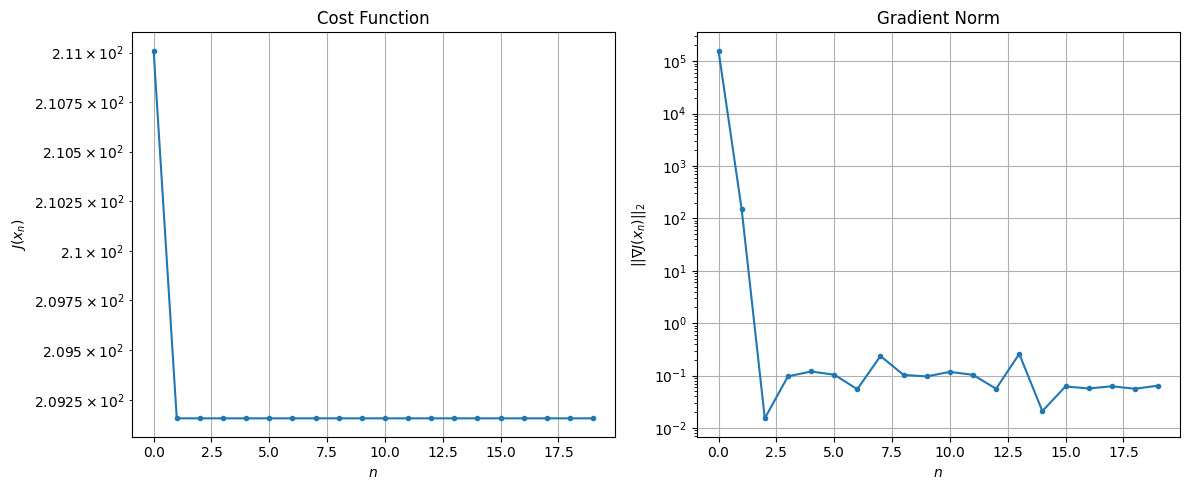


Windows:  14%|█▍        | 48/346 [16:16<1:36:56, 19.52s/it]

Before applying the algorithm
Cost function: 212.19862141652177
Gradient norm: 68837.28958314724
Global estimation error: 1909270584.3189878
Position estimation errors: 0.020786903380642235 m, 1.0228782984828755 m, 1.5565619522492125 m, 2.269478050521108 m

Iteration 1
Cost function: 211.38810719316353 (-0.38%)
Gradient norm: 22.084720270743162 (-99.97%)
Global estimation error: 2.0061915985776566 (-31.67%)
Position estimation errors: 0.010379452294392468 m, 0.7641227038674374 m, 1.466228429204539 m, 1.136208372250446 m

Iteration 2
Cost function: 211.388107003084 (-0.00%)
Gradient norm: 0.029905220425337397 (-99.86%)
Global estimation error: 2.006573576936771 (0.02%)
Position estimation errors: 0.010379452320275718 m, 0.7643854098661196 m, 1.4660760067745515 m, 1.1369026572734093 m

Iteration 3
Cost function: 211.38810710473896 (0.00%)
Gradient norm: 0.1320172452069906 (341.45%)
Global estimation error: 2.006573571479967 (-0.00%)
Position estimation errors: 0.010379452271249793 m, 0.7

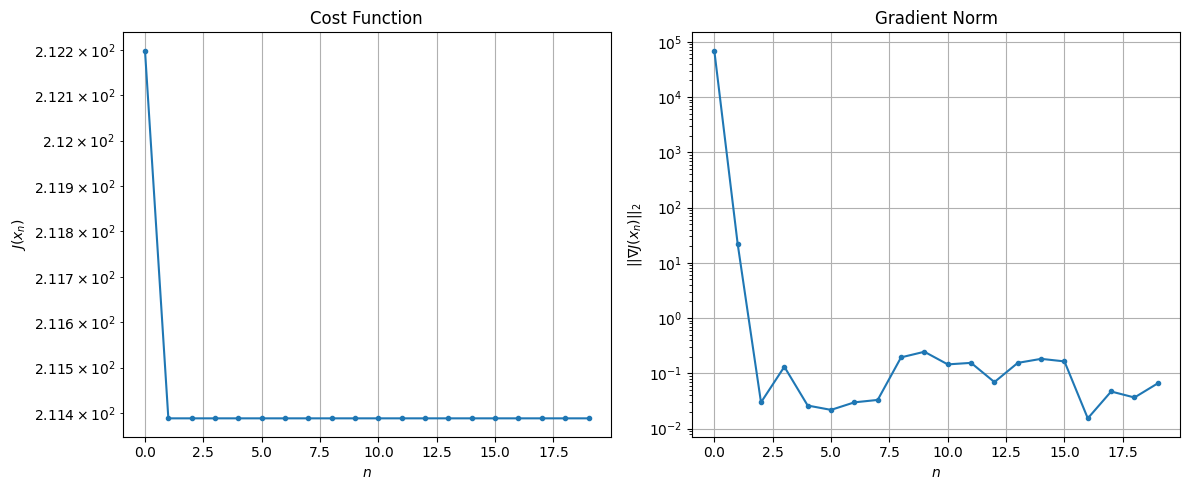


Windows:  14%|█▍        | 49/346 [16:34<1:35:19, 19.26s/it]

Before applying the algorithm
Cost function: 213.33642239904813
Gradient norm: 56020.814541887674
Global estimation error: 1909609382.593411
Position estimation errors: 0.010292407363741402 m, 0.6857147632841359 m, 1.4397785153973566 m, 0.9467489169416183 m

Iteration 1
Cost function: 212.77303457691028 (-0.26%)
Gradient norm: 8.730867079681346 (-99.98%)
Global estimation error: 2.0974671043417774 (13.09%)
Position estimation errors: 0.008895870277653678 m, 0.7975758195758392 m, 1.558969743380007 m, 1.1544460395252827 m

Iteration 2
Cost function: 212.773034686099 (0.00%)
Gradient norm: 0.13265748352919574 (-98.48%)
Global estimation error: 2.097284369382852 (-0.01%)
Position estimation errors: 0.00889587016008468 m, 0.7975629923477245 m, 1.5590470290966145 m, 1.1540184634357464 m

Iteration 3
Cost function: 212.77303451118885 (-0.00%)
Gradient norm: 0.2708623655938316 (104.18%)
Global estimation error: 2.09728437318954 (0.00%)
Position estimation errors: 0.008895869746574697 m, 0.7975

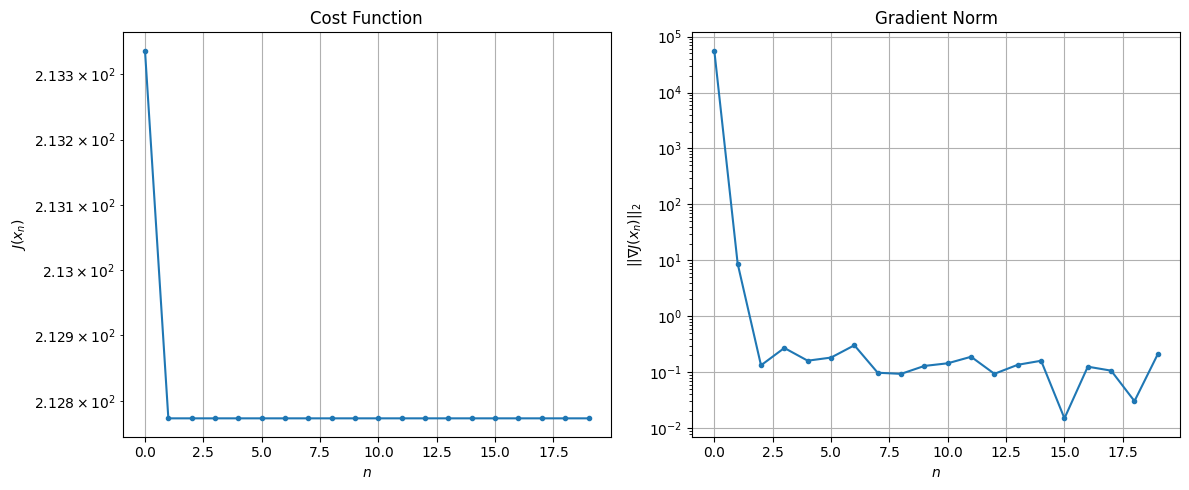


Windows:  14%|█▍        | 50/346 [16:53<1:33:18, 18.92s/it]

Before applying the algorithm
Cost function: 211.71497670276997
Gradient norm: 63727.4028127038
Global estimation error: 1909911515.6913438
Position estimation errors: 0.008997875501543243 m, 0.723927709320834 m, 1.5196604487184606 m, 0.9000139349576556 m

Iteration 1
Cost function: 210.6264212687873 (-0.51%)
Gradient norm: 8.274101167524163 (-99.99%)
Global estimation error: 2.127967024075763 (11.48%)
Position estimation errors: 0.01631526683175432 m, 0.9417763519326687 m, 1.020216947284139 m, 1.6125044544393217 m

Iteration 2
Cost function: 210.6264206670208 (-0.00%)
Gradient norm: 0.2062705047700409 (-97.51%)
Global estimation error: 2.1301204030371417 (0.10%)
Position estimation errors: 0.01631526791281802 m, 0.9420866379453589 m, 1.0192567014534815 m, 1.615770330652608 m

Iteration 3
Cost function: 210.6264207992894 (0.00%)
Gradient norm: 0.0061103040336611915 (-97.04%)
Global estimation error: 2.130120401280178 (-0.00%)
Position estimation errors: 0.016315265580864335 m, 0.942086

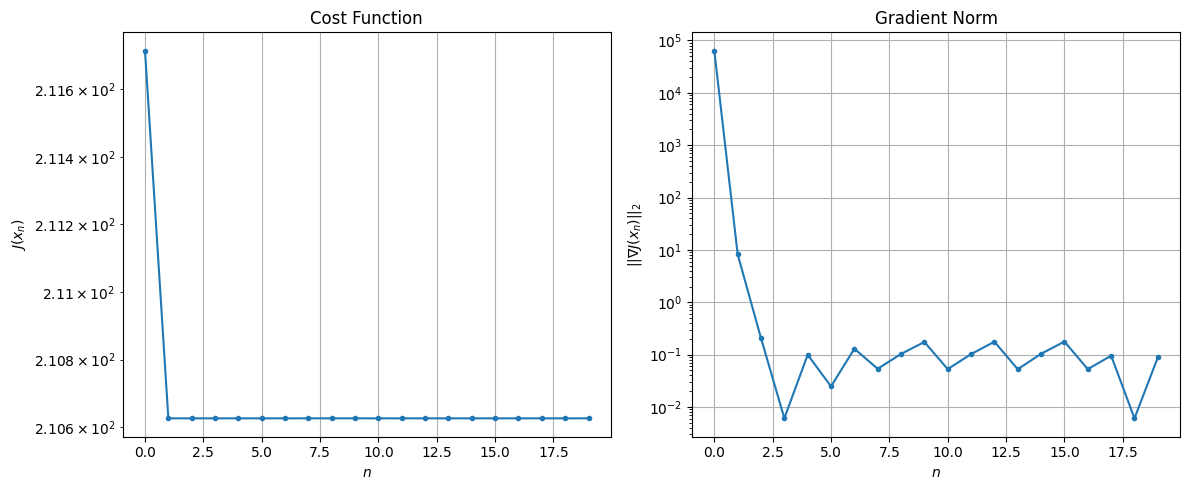


Windows:  15%|█▍        | 51/346 [17:13<1:35:41, 19.46s/it]

Before applying the algorithm
Cost function: 208.63849003755627
Gradient norm: 57537.24359951929
Global estimation error: 1910175663.1321902
Position estimation errors: 0.016458671699785685 m, 0.8417401723427324 m, 1.0394913602959548 m, 1.3866372364746469 m

Iteration 1
Cost function: 207.27783377742807 (-0.65%)
Gradient norm: 124.68256785793459 (-99.78%)
Global estimation error: 2.7228953812684136 (41.33%)
Position estimation errors: 0.02697556872501478 m, 0.6054672274909628 m, 2.0503508328908335 m, 1.6860822360554644 m

Iteration 2
Cost function: 207.2778246521014 (-0.00%)
Gradient norm: 0.1870878747239765 (-99.85%)
Global estimation error: 2.733528774876762 (0.39%)
Position estimation errors: 0.02697557247975203 m, 0.6051808745077203 m, 2.0540197230568444 m, 1.6988766070237182 m

Iteration 3
Cost function: 207.2778245284832 (-0.00%)
Gradient norm: 0.08172382100259615 (-56.32%)
Global estimation error: 2.7335291897293086 (0.00%)
Position estimation errors: 0.026975571353356258 m, 0.6

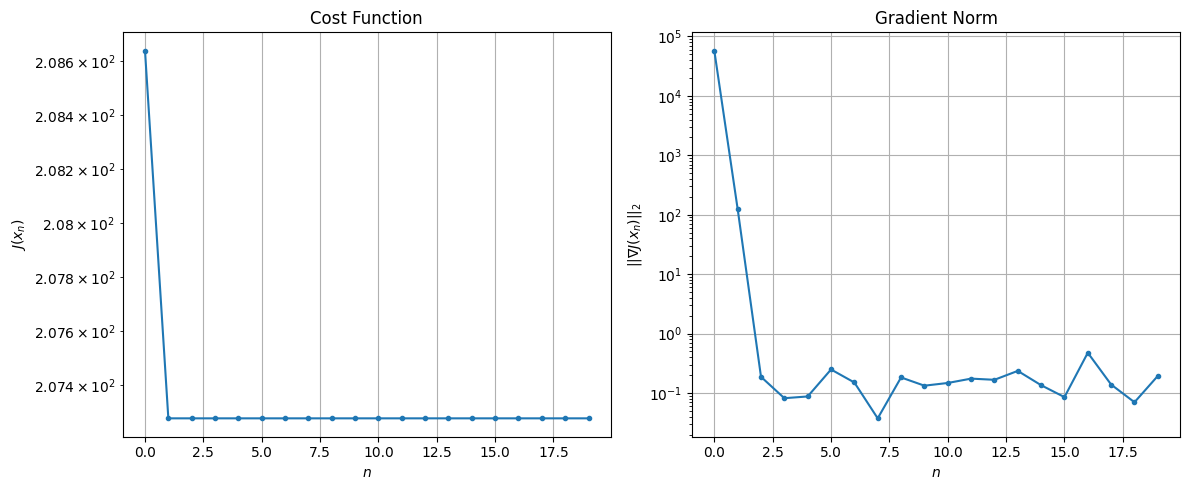


Windows:  15%|█▌        | 52/346 [17:35<1:38:08, 20.03s/it]

Before applying the algorithm
Cost function: 208.97793752916687
Gradient norm: 64838.240958944894
Global estimation error: 1910400680.9873018
Position estimation errors: 0.027434424002647614 m, 0.5615415129827398 m, 2.1152697035713337 m, 1.8541178411677355 m

Iteration 1
Cost function: 207.9813774759898 (-0.48%)
Gradient norm: 19.431593175975326 (-99.97%)
Global estimation error: 2.4527869458309666 (-14.49%)
Position estimation errors: 0.031072545075582846 m, 0.6917009242027797 m, 2.1130744860294626 m, 1.0352019132138524 m

Iteration 2
Cost function: 207.98137688507808 (-0.00%)
Gradient norm: 0.03259883980911604 (-99.83%)
Global estimation error: 2.4510635198670685 (-0.07%)
Position estimation errors: 0.031072548991138014 m, 0.6918625899264782 m, 2.111860883734631 m, 1.0334869652160363 m

Iteration 3
Cost function: 207.98137690569936 (0.00%)
Gradient norm: 0.014583706808001197 (-55.26%)
Global estimation error: 2.45106351185697 (-0.00%)
Position estimation errors: 0.031072546623993003 

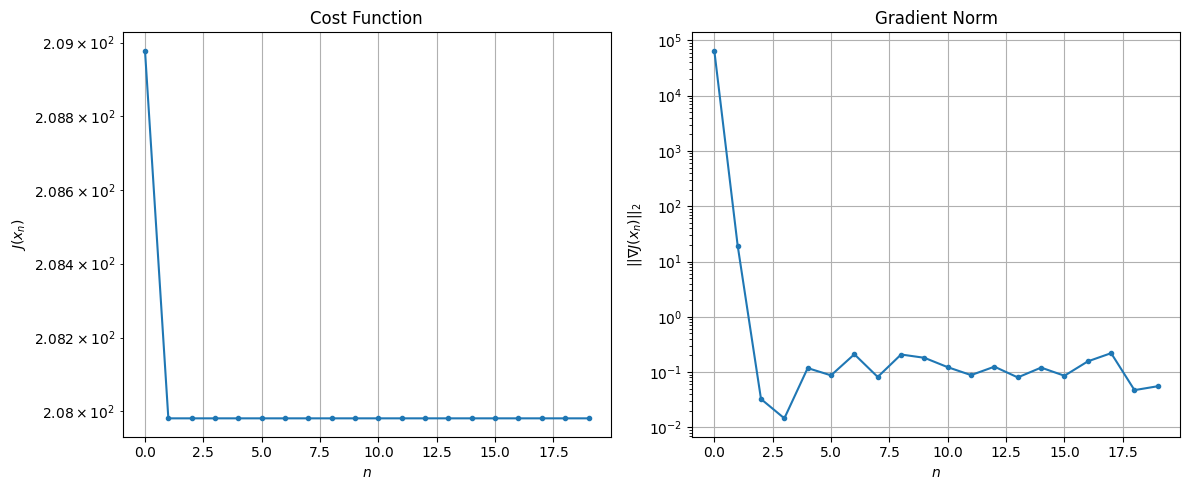


Windows:  15%|█▌        | 53/346 [17:53<1:35:23, 19.53s/it]

Before applying the algorithm
Cost function: 209.97986768703865
Gradient norm: 141864.1598417131
Global estimation error: 1910585639.2813241
Position estimation errors: 0.031202827140008462 m, 0.6383539702897764 m, 2.1376740125511455 m, 1.0863492246034436 m

Iteration 1
Cost function: 208.8292184710835 (-0.55%)
Gradient norm: 18.355043429713326 (-99.99%)
Global estimation error: 2.5348576210122804 (2.15%)
Position estimation errors: 0.0524851042716108 m, 0.5522044470857169 m, 1.9746368986641787 m, 1.4895014598736522 m

Iteration 2
Cost function: 208.8292182679277 (-0.00%)
Gradient norm: 0.26561744665409537 (-98.55%)
Global estimation error: 2.5356752893589114 (0.03%)
Position estimation errors: 0.052485105267905334 m, 0.5521598584913122 m, 1.9749104408076765 m, 1.4905467060153772 m

Iteration 3
Cost function: 208.82921838895388 (0.00%)
Gradient norm: 0.1917430055864471 (-27.81%)
Global estimation error: 2.535675275755923 (-0.00%)
Position estimation errors: 0.05248510351625624 m, 0.552

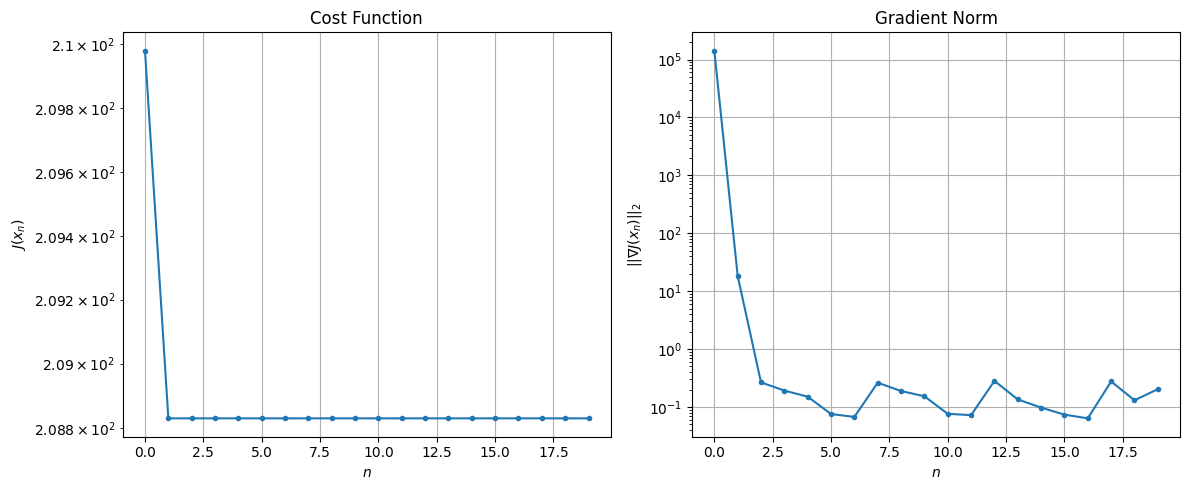


Windows:  16%|█▌        | 54/346 [18:13<1:35:07, 19.55s/it]

Before applying the algorithm
Cost function: 206.44875283881214
Gradient norm: 45095.9704933518
Global estimation error: 1910729750.6014657
Position estimation errors: 0.05085245024068686 m, 0.5934690545986852 m, 2.000652203306198 m, 1.5825465367420364 m

Iteration 1
Cost function: 205.57912012985577 (-0.42%)
Gradient norm: 8.40094135501447 (-99.98%)
Global estimation error: 3.443346763527114 (31.45%)
Position estimation errors: 0.0686641601353624 m, 0.5606120751149728 m, 2.3266752430689666 m, 2.4747116600677157 m

Iteration 2
Cost function: 205.57911981032177 (-0.00%)
Gradient norm: 0.18425092204510574 (-97.81%)
Global estimation error: 3.4413919978969805 (-0.06%)
Position estimation errors: 0.06866415937485841 m, 0.5605601757103711 m, 2.325943092636833 m, 2.472691724704483 m

Iteration 3
Cost function: 205.57911990422298 (0.00%)
Gradient norm: 0.17227893475262254 (-6.50%)
Global estimation error: 3.4413919926329095 (-0.00%)
Position estimation errors: 0.06866415929585466 m, 0.5605601

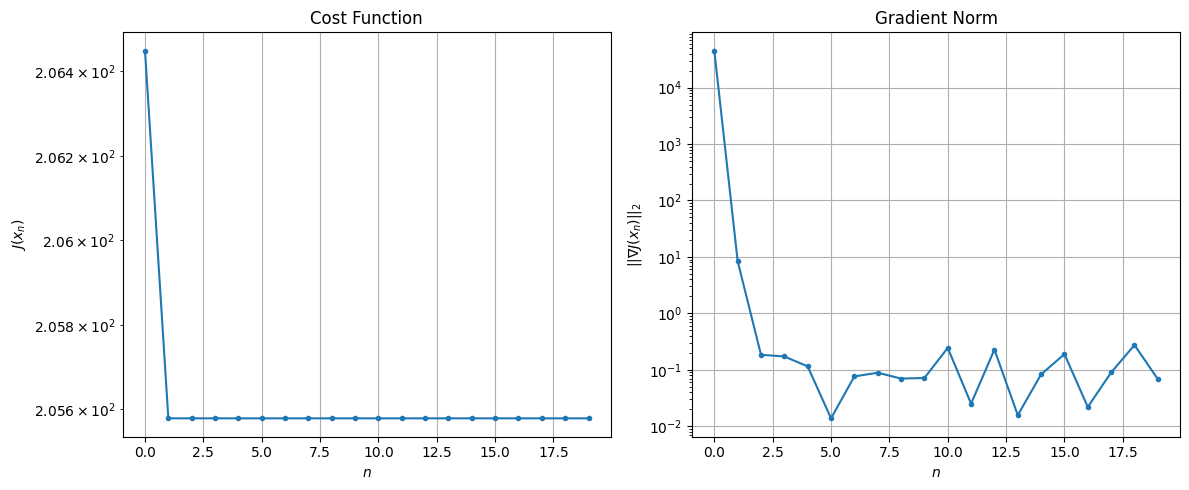


Windows:  16%|█▌        | 55/346 [18:29<1:29:51, 18.53s/it]

Before applying the algorithm
Cost function: 210.58931919450478
Gradient norm: 175705.15284624128
Global estimation error: 1910832339.7141638
Position estimation errors: 0.06486399349916543 m, 0.6117382240179414 m, 2.3554312997177145 m, 2.610034916739799 m

Iteration 1
Cost function: 209.2887766770514 (-0.62%)
Gradient norm: 141.01922901749123 (-99.92%)
Global estimation error: 1.6174160014004113 (-54.68%)
Position estimation errors: 0.06270052047050237 m, 0.5082223992025124 m, 1.0928792870115096 m, 1.0767610233898055 m

Iteration 2
Cost function: 209.2887613570083 (-0.00%)
Gradient norm: 0.16086314963439263 (-99.89%)
Global estimation error: 1.6106471440016006 (-0.42%)
Position estimation errors: 0.06270052569777246 m, 0.5048197693467773 m, 1.0990927130607222 m, 1.0617868314059027 m

Iteration 3
Cost function: 209.28876128906884 (-0.00%)
Gradient norm: 0.3746667126183557 (132.91%)
Global estimation error: 1.6106469638632372 (-0.00%)
Position estimation errors: 0.0627005251222347 m, 0.

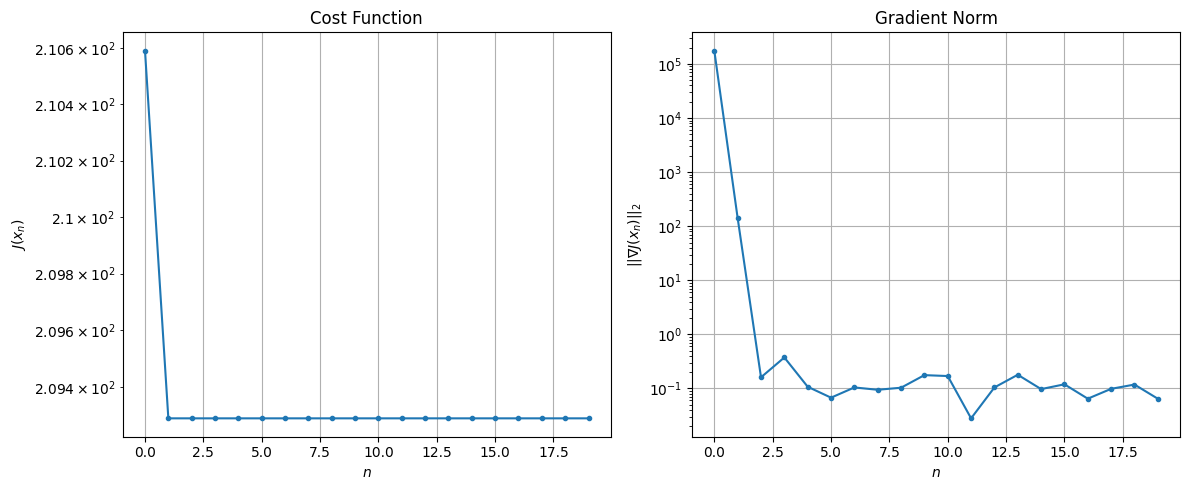


Windows:  16%|█▌        | 56/346 [18:48<1:30:52, 18.80s/it]

Before applying the algorithm
Cost function: 210.0308884597127
Gradient norm: 150491.96563815605
Global estimation error: 1910893028.7543154
Position estimation errors: 0.05926678287188504 m, 0.41235220488138496 m, 1.12744306807196 m, 0.9006953177851031 m

Iteration 1
Cost function: 208.5411987175957 (-0.71%)
Gradient norm: 19.860641823777815 (-99.99%)
Global estimation error: 2.26545486556637 (50.83%)
Position estimation errors: 0.05505043077733678 m, 1.2814085709917797 m, 0.8264059021676274 m, 1.6746015609022231 m

Iteration 2
Cost function: 208.5411952864693 (-0.00%)
Gradient norm: 0.05362274918813337 (-99.73%)
Global estimation error: 2.260224420406986 (-0.23%)
Position estimation errors: 0.055050432838223404 m, 1.2777734948847113 m, 0.8279280694639009 m, 1.669551950682248 m

Iteration 3
Cost function: 208.54119529025144 (0.00%)
Gradient norm: 0.039846404646095866 (-25.69%)
Global estimation error: 2.2602243921048424 (-0.00%)
Position estimation errors: 0.05505043166343103 m, 1.277

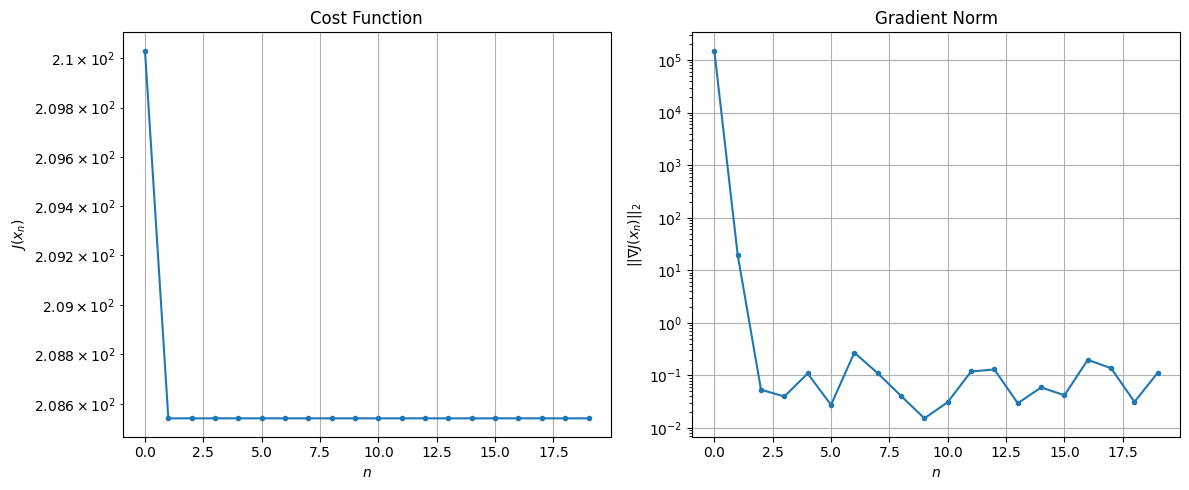


Windows:  16%|█▋        | 57/346 [19:08<1:32:25, 19.19s/it]

Before applying the algorithm
Cost function: 209.7106576455941
Gradient norm: 112691.06918232182
Global estimation error: 1910911508.7635972
Position estimation errors: 0.05261406399448559 m, 1.1458372142890196 m, 0.8404571687569565 m, 1.5476956414068972 m

Iteration 1
Cost function: 207.93933802744988 (-0.84%)
Gradient norm: 147.4627865033486 (-99.87%)
Global estimation error: 5.586174099655113 (165.78%)
Position estimation errors: 0.03453795416306603 m, 1.4080444318624015 m, 1.0102334042077834 m, 5.310458924267193 m

Iteration 2
Cost function: 207.9393216550126 (-0.00%)
Gradient norm: 0.024749122926357794 (-99.98%)
Global estimation error: 5.588285692722391 (0.04%)
Position estimation errors: 0.034537951368395915 m, 1.4072522884320922 m, 1.0105832533556942 m, 5.312823451244234 m

Iteration 3
Cost function: 207.93932161230342 (-0.00%)
Gradient norm: 0.022078968817832976 (-10.79%)
Global estimation error: 5.588285893447023 (0.00%)
Position estimation errors: 0.034537951376888774 m, 1.4

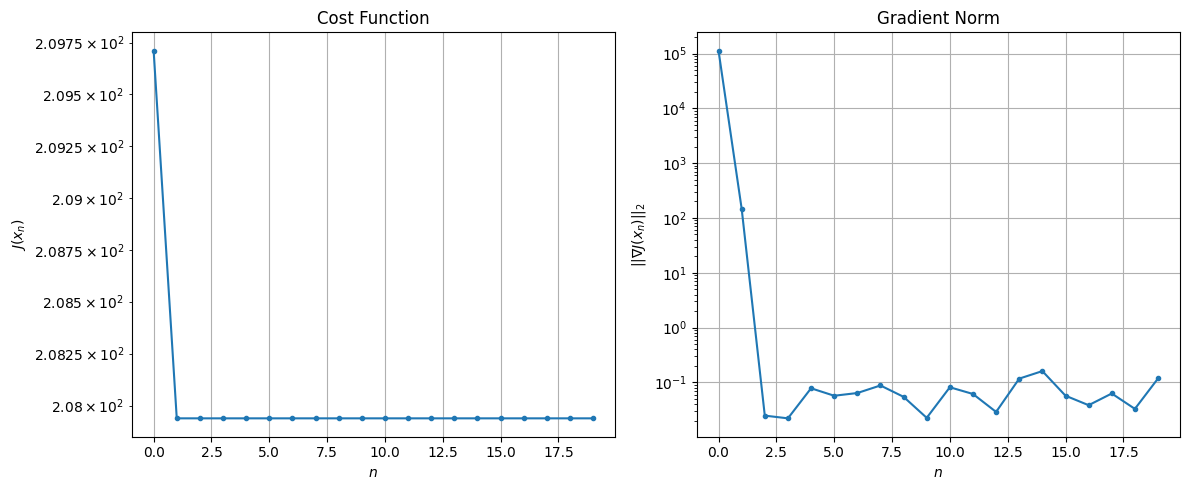


Windows:  17%|█▋        | 58/346 [19:30<1:35:59, 20.00s/it]

Before applying the algorithm
Cost function: 208.8848493926118
Gradient norm: 237365.4347993256
Global estimation error: 1910887710.4418488
Position estimation errors: 0.03387026122916708 m, 1.3259136466672765 m, 0.9455102886314488 m, 5.370069555676251 m

Iteration 1
Cost function: 207.97677743291305 (-0.43%)
Gradient norm: 13.394748611102425 (-99.99%)
Global estimation error: 4.999521402765693 (-10.91%)
Position estimation errors: 0.03391401779888951 m, 1.7490006595052103 m, 0.7511459134941977 m, 4.62285965691293 m

Iteration 2
Cost function: 207.97677712291062 (-0.00%)
Gradient norm: 0.21800567016763295 (-98.37%)
Global estimation error: 4.997207378736852 (-0.05%)
Position estimation errors: 0.033914017282842546 m, 1.7483620297504407 m, 0.7505115525692964 m, 4.620701770550259 m

Iteration 3
Cost function: 207.97677715630869 (0.00%)
Gradient norm: 0.268451422011147 (23.14%)
Global estimation error: 4.997207363724553 (-0.00%)
Position estimation errors: 0.03391402039338888 m, 1.7483620

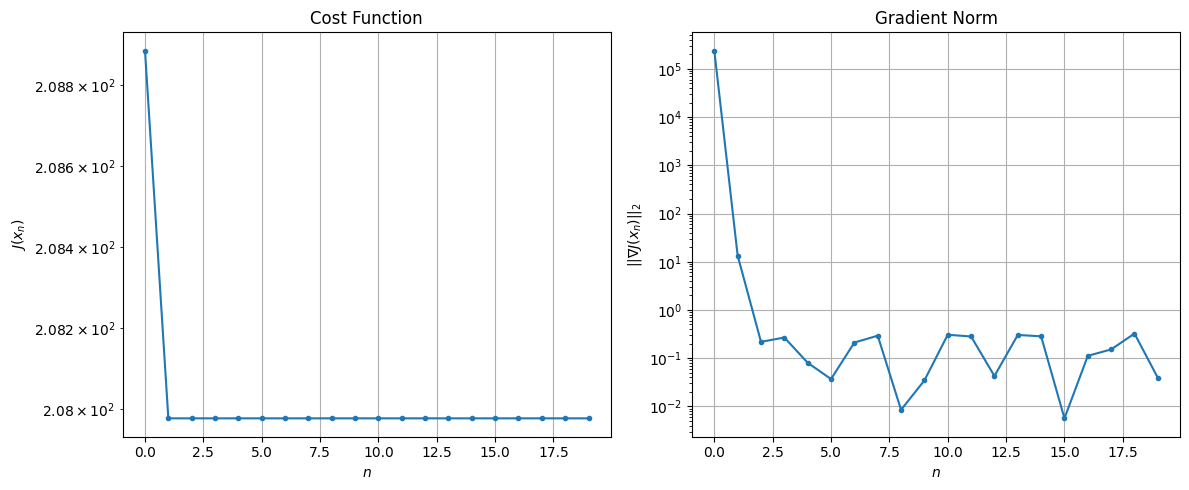


Windows:  17%|█▋        | 59/346 [19:50<1:34:56, 19.85s/it]

Before applying the algorithm
Cost function: 208.48374856809377
Gradient norm: 128202.87209910213
Global estimation error: 1910821657.817555
Position estimation errors: 0.03226693388038596 m, 1.6264073718188798 m, 0.6822023096673583 m, 4.608504353277237 m

Iteration 1
Cost function: 207.3684255043385 (-0.53%)
Gradient norm: 77.24774540712382 (-99.94%)
Global estimation error: 2.832171407140767 (-42.61%)
Position estimation errors: 0.03501438597861926 m, 1.5853308322942408 m, 0.28508041680770263 m, 2.329251660880135 m

Iteration 2
Cost function: 207.36842070596165 (-0.00%)
Gradient norm: 0.2729039372408519 (-99.65%)
Global estimation error: 2.8235267942801885 (-0.31%)
Position estimation errors: 0.03501438764365253 m, 1.5844653748299702 m, 0.28504627940254496 m, 2.3193285123179725 m

Iteration 3
Cost function: 207.3684206452191 (-0.00%)
Gradient norm: 0.21909650995186464 (-19.72%)
Global estimation error: 2.8235266764684703 (-0.00%)
Position estimation errors: 0.03501438830958397 m, 1.5

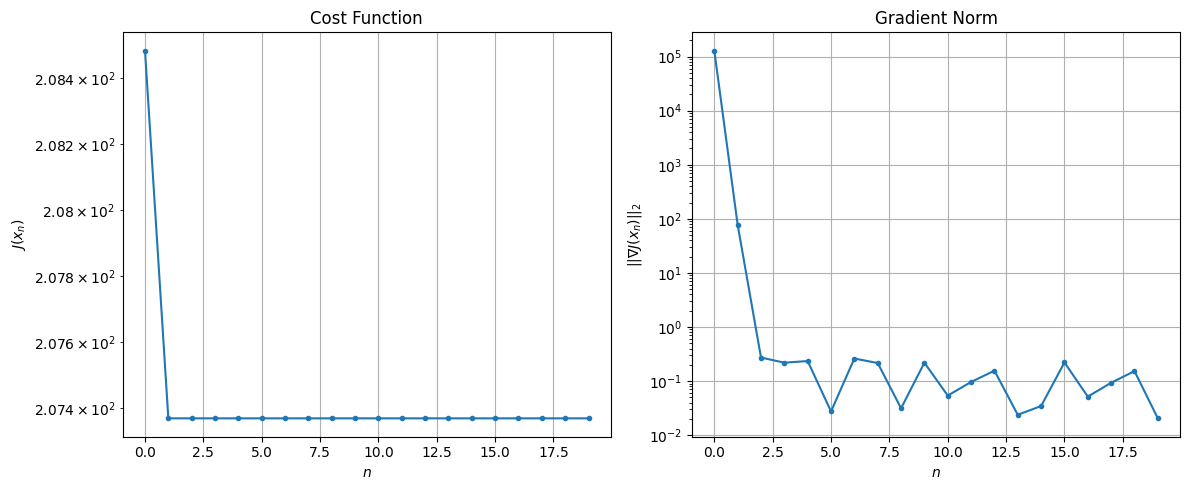


Windows:  17%|█▋        | 60/346 [20:08<1:32:03, 19.31s/it]

Before applying the algorithm
Cost function: 205.90153128495737
Gradient norm: 95769.11248293026
Global estimation error: 1910713699.6669066
Position estimation errors: 0.032761011916029446 m, 1.432234686667129 m, 0.2410040717218224 m, 2.239848182493485 m

Iteration 1
Cost function: 204.34635241684344 (-0.76%)
Gradient norm: 44.44816940154464 (-99.95%)
Global estimation error: 2.0209908202008737 (-24.30%)
Position estimation errors: 0.05078001412308603 m, 1.4885408933282922 m, 1.2736953121058525 m, 0.49370620671631593 m

Iteration 2
Cost function: 204.34635066212527 (-0.00%)
Gradient norm: 0.09345217249654068 (-99.79%)
Global estimation error: 2.0212396521975386 (0.01%)
Position estimation errors: 0.05078001628782167 m, 1.4889125879769443 m, 1.273383906901884 m, 0.4944068483747657 m

Iteration 3
Cost function: 204.34635047857734 (-0.00%)
Gradient norm: 0.03623531598764058 (-61.23%)
Global estimation error: 2.021239653387345 (0.00%)
Position estimation errors: 0.050780016691047036 m, 1.

In [ ]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []
for m in tqdm(range(M), desc="MC run", leave=True):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    Y = np.zeros((o, 1, K))
    for k in range(K):
        Y[:, :, k] = h(X_true[:, :, k]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((o, 1)), size=(o, 1))

    # Cold-start
    x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
    
    # Apply the algorithm
    X_est = np.zeros((n, 1, K))
    for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
        centralized_newton = CentralizedNewton()
        x_init, x_est = centralized_newton.solve(k, dt, Y, x_init, X_true[:, :, k - H + 1])
        X_est[:, :, k] = x_est
        
        give_me_the_plots(centralized_newton)

        if k == 0: # Check divergence in the beginning
            position_estimation_error_init_1, position_estimation_error_init_2, position_estimation_error_init_3, position_estimation_error_init_4 = [], [], [], []
            x_est_tau = x_est
            for tau in range(H):
                position_estimation_error_init_1.append(np.linalg.norm(x_est_tau[:n_p, :] - X_true[:n_p, :, tau]))
                position_estimation_error_init_2.append(np.linalg.norm(x_est_tau[n_x:n_x + n_p, :] - X_true[n_x:n_x + n_p, :, tau]))
                position_estimation_error_init_3.append(np.linalg.norm(x_est_tau[2*n_x:2*n_x + n_p, :] - X_true[2*n_x:2*n_x + n_p, :, tau]))    
                position_estimation_error_init_4.append(np.linalg.norm(x_est_tau[3*n_x:3*n_x + n_p, :] - X_true[3*n_x:3*n_x + n_p, :, tau]))
                x_est_tau = f(dt, x_est_tau)
            rmse_init_1 = np.sqrt(np.mean(np.array(position_estimation_error_init_1) ** 2))
            rmse_init_2 = np.sqrt(np.mean(np.array(position_estimation_error_init_2) ** 2))
            rmse_init_3 = np.sqrt(np.mean(np.array(position_estimation_error_init_3) ** 2))
            rmse_init_4 = np.sqrt(np.mean(np.array(position_estimation_error_init_4) ** 2))
            if rmse_init_1 > invalid_rmse or rmse_init_2 > invalid_rmse or rmse_init_3 > invalid_rmse or rmse_init_4 > invalid_rmse:
                print(f"This Monte Carlo run #{m + 1} diverged!")
            else:
                first_round_stop_iteration.append(centralized_newton.iterations)
        else:
            K_minus_H_next_rounds_stop_iteration.append(centralized_newton.iterations)

        # Warm-start
        x_init = f(dt, x_init)

    # After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
    position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
    rmse_1, rmse_2, rmse_3, rmse_4 = [], [], [], []
    for k in range(H - 1, K):
        position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
        position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
        position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
        position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
    rmse_m_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
    rmse_m_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
    rmse_m_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
    rmse_m_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
    print(f'This MC run RMSE for the {K - H + 1} timestamps:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > invalid_rmse or rmse_m_2 > invalid_rmse or rmse_m_3 > invalid_rmse or rmse_m_4 > invalid_rmse:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the {K - H + 1} timestamps for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of CentralizedNewton converged with {np.mean(first_round_stop_iteration)} iterations on average.')
print(f'The next {K - H} rounds of CentralizedNewton converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

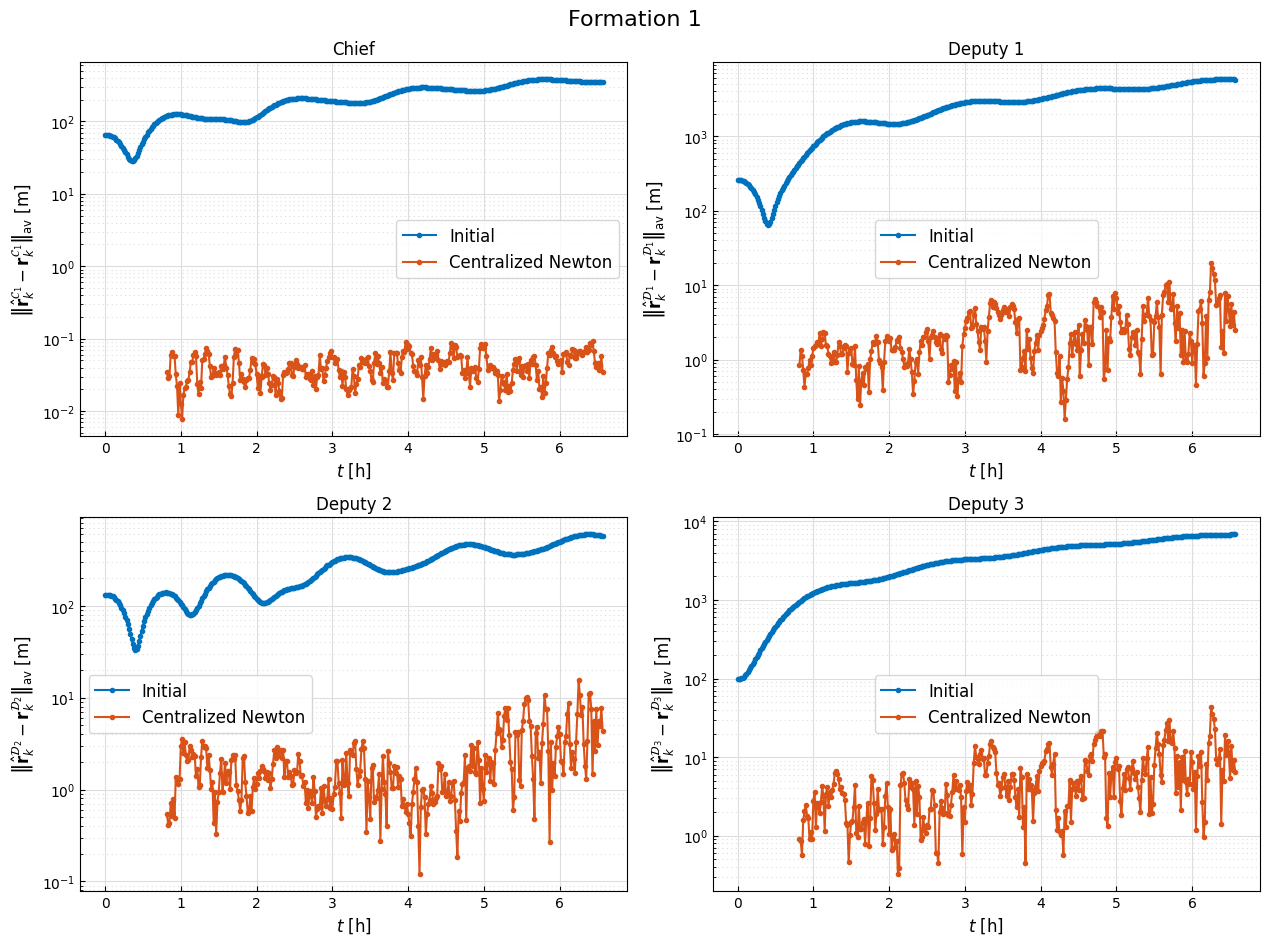

In [16]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()